In [1]:
#import
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import matplotlib
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import snowflake.connector
import datetime as dt
import folium
import geopandas as gpd
import calendar
import scipy
import h3
import geojson as gjs
import pandasql as ps

#connect to snowflake
con = snowflake.connector.connect(
user='elliot.safo@deliveroo.co.uk',
account='deliveroo.eu-central-1',
authenticator='externalbrowser',
warehouse='BI_DEVELOPMENT'
)

/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/snowflake/connector/options.py:97: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  _expected_pyarrow_version,
/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


# Get top 10 cities in each market

In [2]:
q_cities = '''WITH TMP AS (
SELECT
country_name
,city_name
,count(*) as order_volume
,DENSE_RANK() OVER (PARTITION BY country_name ORDER BY order_volume DESC) as rank
FROM production.denormalised.orders
WHERE order_date >= current_date()-61
GROUP BY 1,2
ORDER BY 1,4)

SELECT
*
FROM TMP
WHERE rank <= 10'''

df_cities = pd.read_sql(q_cities,con)

# 1a) Restaurant Classification

In [2]:
q_rx_geo = '''WITH TMP AS (
SELECT
country_name
,city_name
,count(*) as order_volume
,DENSE_RANK() OVER (PARTITION BY country_name ORDER BY order_volume DESC) as rank
FROM production.denormalised.orders
WHERE order_date >= current_date()-61
GROUP BY 1,2
ORDER BY 1,4)

,TMP2 AS (SELECT
*
FROM TMP
WHERE rank <= 10)

select restaurant_id, restaurant_zone_id, restaurant_city_id, restaurant_city, restaurant_business_unit_name, restaurant_geo_long, restaurant_geo_lat from production.reference.restaurant_with_company
where restaurant_city in (select city_name from tmp2) order by restaurant_zone_id '''

df_rx_geo = pd.read_sql(q_rx_geo, con)
df_rx_geo.head()

,RESTAURANT_ID,RESTAURANT_ZONE_ID,RESTAURANT_CITY_ID,RESTAURANT_CITY,RESTAURANT_BUSINESS_UNIT_NAME,RESTAURANT_GEO_LONG,RESTAURANT_GEO_LAT
0,90396,1,1,London,London,-0.189066,51.502003
1,289539,1,1,London,London,-0.179002,51.487352
2,46258,1,1,London,London,-0.149510,51.492941
3,284778,1,1,London,London,-0.159169,51.498768
4,7,1,1,London,London,-0.177411,51.492606


In [3]:
lst=[]

for i in range(df_rx_geo.shape[0]):
    hex1=0
    hex1 = h3.geo_to_h3(df_rx_geo['RESTAURANT_GEO_LAT'][i],df_rx_geo['RESTAURANT_GEO_LONG'][i], resolution=6)
    lst.append(hex1)
df_rx_geo['hex_ID'] = lst


In [74]:
# df_rx_geo.to_csv('rx_hex4_assignment.csv')
df_rx_geo.to_csv('rx_hex8_assignment.csv')


In [4]:
#total restaurants per hex
df_rx_counts = df_rx_geo.groupby(['RESTAURANT_CITY_ID','RESTAURANT_CITY','hex_ID']).size().to_frame().reset_index().rename(columns={0:'TOTAL_RESTAURANTS_IN_HEX'})
df_rx_counts.head()

,RESTAURANT_CITY_ID,RESTAURANT_CITY,hex_ID,TOTAL_RESTAURANTS_IN_HEX
0,1,London,86194a517ffffff,3
1,1,London,86194a587ffffff,2
2,1,London,86194a5a7ffffff,43
3,1,London,86194a997ffffff,2
4,1,London,86194a9a7ffffff,4


In [19]:
df_rx_counts



,RESTAURANT_CITY_ID,RESTAURANT_CITY,hex_ID,TOTAL_RESTAURANTS_IN_HEX
0,1,London,84194a5ffffffff,229
1,1,London,84194a9ffffffff,8
2,1,London,84194adffffffff,27295
3,1,London,84194e3ffffffff,585
4,1,London,84194e5ffffffff,354
...,...,...,...,...
185,2407,Ajman,8443acdffffffff,345
186,2488,Naas,84182c1ffffffff,48
187,2541,Ras Al Khaimah,8443ac1ffffffff,3
188,2541,Ras Al Khaimah,8443acbffffffff,255


In [28]:
#This shows which hexes span more than one city

test = ps.sqldf('''
SELECT DISTINCT
hex_id
,count(distinct RESTAURANT_CITY) as cities
FROM df_rx_counts
group by 1
having cities > 1
'''
)

test

,hex_ID,cities
0,84182c1ffffffff,2
1,8419423ffffffff,2
2,8419425ffffffff,2
3,8419435ffffffff,2
4,84194d3ffffffff,2
5,8419527ffffffff,2
6,84195c9ffffffff,2
7,84195cbffffffff,2
8,8419683ffffffff,2
9,8419695ffffffff,3


In [5]:
#avg restaurants per hex per city
df_city_rx_avg = df_rx_counts.groupby(['RESTAURANT_CITY_ID','RESTAURANT_CITY'])['TOTAL_RESTAURANTS_IN_HEX'].median().to_frame().reset_index().rename(columns={'TOTAL_RESTAURANTS_IN_HEX':'AVG_RX_PER_HEX_PER_CITY'})
df_city_rx_avg.head()

,RESTAURANT_CITY_ID,RESTAURANT_CITY,AVG_RX_PER_HEX_PER_CITY
0,1,London,42.0
1,2,Brighton,17.5
2,3,Manchester,64.0
3,5,Dublin,27.0
4,6,Paris,45.0


In [6]:
df_city_rx_hex_comparison = df_rx_counts.merge(df_city_rx_avg, how='left', on='RESTAURANT_CITY_ID').drop(columns='RESTAURANT_CITY_y').rename(columns={'RESTAURANT_CITY_x':'RESTAURANT_CITY'})
df_city_rx_hex_comparison.head()

,RESTAURANT_CITY_ID,RESTAURANT_CITY,hex_ID,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY
0,1,London,86194a517ffffff,3,42.0
1,1,London,86194a587ffffff,2,42.0
2,1,London,86194a5a7ffffff,43,42.0
3,1,London,86194a997ffffff,2,42.0
4,1,London,86194a9a7ffffff,4,42.0


In [7]:
df_rx_classification = ps.sqldf('''
SELECT DISTINCT
*
,CASE WHEN TOTAL_RESTAURANTS_IN_HEX < AVG_RX_PER_HEX_PER_CITY THEN 'Low'
WHEN TOTAL_RESTAURANTS_IN_HEX >= AVG_RX_PER_HEX_PER_CITY THEN 'High'
ELSE NULL
END AS rx_classification
FROM df_city_rx_hex_comparison
'''
)

df_rx_classification.head()

,RESTAURANT_CITY_ID,RESTAURANT_CITY,hex_ID,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification
0,1,London,86194a517ffffff,3,42.0,Low
1,1,London,86194a587ffffff,2,42.0,Low
2,1,London,86194a5a7ffffff,43,42.0,High
3,1,London,86194a997ffffff,2,42.0,Low
4,1,London,86194a9a7ffffff,4,42.0,Low


In [18]:
print(df_rx_classification['hex_ID'].count())
print(df_rx_classification['hex_ID'].nunique())

190
165


In [19]:
df_rx_classification.to_csv('rx_classification.csv')


# 1b) Customer classification

In [8]:
q_cx_geo = '''WITH TMP AS (
SELECT
country_name
,city_name
,count(*) as order_volume
,DENSE_RANK() OVER (ORDER BY order_volume DESC) as rank
FROM production.denormalised.orders
WHERE order_date >= current_date()-61
GROUP BY 1,2
ORDER BY 1,4)

,TMP2 AS (
SELECT
*
FROM TMP
WHERE rank <= 10)

,latest as
(select
user_id
,max(created_at) as max_created_at
from production.denormalised.denormalised_user_address_with_postcode
where city_name in (select city_name from tmp2)
group by 1
)

SELECT
a.user_id
,a.created_at
,a.customer_zone_id
,a.city_id
,a.city_name as city
,a.geo_long
,a.geo_lat
FROM production.denormalised.denormalised_user_address_with_postcode a
INNER JOIN latest b
ON a.user_id=b.user_id AND a.created_at=b.max_created_at
'''

df_cx_geo = pd.read_sql(q_cx_geo,con)
df_cx_geo.head()

,USER_ID,CREATED_AT,CUSTOMER_ZONE_ID,CITY_ID,CITY,GEO_LONG,GEO_LAT
0,58571796,2021-12-05 17:46:16.083934,2636.0,6,Paris,2.263806,48.719085
1,35922952,2021-12-05 17:55:26.935426,1072.0,1,London,-0.443808,51.367206
2,22640282,2021-12-05 18:09:58.350740,12.0,1,London,-0.068387,51.501269
3,38170964,2021-12-05 18:38:14.221576,73.0,6,Paris,2.347201,48.849154
4,15427696,2020-04-28 17:51:05.929431,29.0,1,London,-0.190010,51.427892


In [10]:
lst2=[]

for i in range(df_cx_geo.shape[0]):
    hex2=0
    hex2 = h3.geo_to_h3(df_cx_geo['GEO_LAT'][i],df_cx_geo['GEO_LONG'][i], resolution=6)
    lst2.append(hex2)
df_cx_geo['hex_ID'] = lst2


In [ ]:
#total customers per hex
df_cx_counts = df_cx_geo.groupby(['CITY_ID','CITY','hex_ID']).size().to_frame().reset_index().rename(columns={0:'TOTAL_CUSTOMERS_IN_HEX'})
df_cx_counts.head()

In [26]:
test = ps.sqldf('''
SELECT DISTINCT
hex_ID
,count(CITY) as cities
FROM df_cx_counts
group by 1
having cities > 1
'''
)

test.head()

PandaSQLException: (sqlite3.OperationalError) no such table: df_cx_counts
[SQL: 
SELECT DISTINCT
hex_ID
,count(CITY) as cities
FROM df_cx_counts
group by 1
having cities > 1
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [ ]:
#avg customers per hex per city
df_city_cx_avg = df_cx_counts.groupby(['CITY_ID','CITY'])['TOTAL_CUSTOMERS_IN_HEX'].median().to_frame().reset_index().rename(columns={'TOTAL_CUSTOMERS_IN_HEX':'AVG_CX_PER_HEX_PER_CITY'})
df_city_cx_avg.head()

In [ ]:
df_city_cx_hex_comparison = df_cx_counts.merge(df_city_cx_avg, how='left', on='CITY_ID').drop(columns='CITY_y').rename(columns={'CITY_x':'CITY'})
df_city_cx_hex_comparison.head()

In [ ]:
df_cx_classification = ps.sqldf('''
SELECT
*
,CASE WHEN TOTAL_CUSTOMERS_IN_HEX < AVG_CX_PER_HEX_PER_CITY THEN 'Low'
WHEN TOTAL_CUSTOMERS_IN_HEX >= AVG_CX_PER_HEX_PER_CITY THEN 'High'
ELSE NULL
END AS cx_classification
FROM df_city_cx_hex_comparison
'''
)

df_cx_classification.reset_index()
df_cx_classification.head()

In [14]:
df_full_classification = df_cx_classification.merge(df_rx_classification, how='outer', left_on=['hex_ID','CITY_ID'],right_on=['hex_ID','RESTAURANT_CITY_ID']).rename(columns=
{'rx_classification':'rx_classification_tmp'})
df_full_classification.head()

,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification_tmp
0,1.0,London,861825877ffffff,1.0,1.0,High,NaN,NaN,NaN,NaN,NaN
1,1.0,London,861862807ffffff,1.0,1.0,High,NaN,NaN,NaN,NaN,NaN
2,1.0,London,861862827ffffff,1.0,1.0,High,NaN,NaN,NaN,NaN,NaN
3,1.0,London,861870d87ffffff,1.0,1.0,High,NaN,NaN,NaN,NaN,NaN
4,1.0,London,861874327ffffff,1.0,1.0,High,NaN,NaN,NaN,NaN,NaN


array([      nan, 1.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 6.000e+00,
       9.000e+00, 1.100e+01, 1.200e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       2.100e+01, 2.300e+01, 2.700e+01, 3.700e+01, 3.900e+01, 4.000e+01,
       4.300e+01, 4.400e+01, 4.500e+01, 4.600e+01, 4.700e+01, 4.800e+01,
       5.000e+01, 5.100e+01, 5.300e+01, 5.400e+01, 5.600e+01, 5.700e+01,
       5.800e+01, 6.000e+01, 6.100e+01, 6.400e+01, 6.600e+01, 6.800e+01,
       7.300e+01, 8.200e+01, 8.400e+01, 8.500e+01, 8.800e+01, 1.150e+02,
       1.160e+02, 1.180e+02, 1.190e+02, 1.350e+02, 1.460e+02, 1.480e+02,
       1.490e+02, 1.500e+02, 1.530e+02, 1.550e+02, 1.570e+02, 1.800e+02,
       1.810e+02, 1.820e+02, 1.920e+02, 1.930e+02, 1.970e+02, 2.240e+02,
       2.320e+02, 2.350e+02, 2.390e+02, 2.420e+02, 2.700e+02, 3.020e+02,
       3.040e+02, 4.130e+02, 4.270e+02, 5.860e+02, 7.400e+02, 1.123e+03,
       2.382e+03, 2.384e+03, 2.386e+03, 2.388e+03, 2.391e+03, 2.407e+03,
       2.488e+03, 2.541e+03, 2.576e+03])

In [15]:
df_full_classification = df_full_classification.fillna(0)
df_full_classification.head()

,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification_tmp
0,1.0,London,861825877ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0
1,1.0,London,861862807ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0
2,1.0,London,861862827ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0
3,1.0,London,861870d87ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0
4,1.0,London,861874327ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0


In [16]:
df_full_classification_final = ps.sqldf('''
with tmp as(
SELECT
*
,CASE WHEN rx_classification_tmp = 0 THEN 'Low'
ELSE rx_classification_tmp
END AS rx_classification
FROM df_full_classification
)

SELECT
*
,CASE WHEN rx_classification = 'Low' AND cx_classification = 'Low' THEN 'Sparse'
WHEN rx_classification = 'High' AND cx_classification = 'Low' THEN 'Downtown'
WHEN rx_classification = 'Low' AND cx_classification = 'High' THEN 'Suburban'
WHEN rx_classification = 'High' AND cx_classification = 'High' THEN 'Dense'
ELSE NULL
END AS hex_classification
FROM tmp
'''
)


df_full_classification_final.reset_index().drop(columns='index')

,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification_tmp,rx_classification,hex_classification
0,1.0,London,861825877ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0,Low,Suburban
1,1.0,London,861862807ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0,Low,Suburban
2,1.0,London,861862827ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0,Low,Suburban
3,1.0,London,861870d87ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0,Low,Suburban
4,1.0,London,861874327ffffff,1.0,1.0,High,0.0,0,0.0,0.0,0,Low,Suburban
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4279,2541.0,Ras Al Khaimah,8643acb9fffffff,164.0,231.5,Low,2541.0,Ras Al Khaimah,1.0,9.0,Low,Low,Sparse
4280,2576.0,Groningen,86196d857ffffff,970.0,970.0,High,2576.0,Groningen,1.0,42.5,Low,Low,Suburban
4281,2576.0,Groningen,86196d85fffffff,7674.0,970.0,High,2576.0,Groningen,84.0,42.5,High,High,Dense
4282,2576.0,Groningen,86196d8efffffff,48.0,970.0,Low,0.0,0,0.0,0.0,0,Low,Sparse


In [76]:
# city_hex_counts = df_full_classification_final.groupby('CITY')['hex_ID'].size().to_frame().reset_index().rename(columns={'hex_ID':'total_hexes_in_city'})
# df_full_classification_final = df_full_classification_final.merge(city_hex_counts, how='left',on='CITY')
# df_full_classification_final



,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification_tmp,rx_classification,hex_classification,total_hexes_in_city
0,1,London,8418259ffffffff,1,61525.324503,Low,0.0,0.0,0,Low,Sparse,159
1,1,London,8418629ffffffff,2,61525.324503,Low,0.0,0.0,0,Low,Sparse,159
2,1,London,841870dffffffff,1,61525.324503,Low,0.0,0.0,0,Low,Sparse,159
3,1,London,8418743ffffffff,1,61525.324503,Low,0.0,0.0,0,Low,Sparse,159
4,16,Leeds,8418743ffffffff,1,16207.741935,Low,0.0,0.0,0,Low,Sparse,33
...,...,...,...,...,...,...,...,...,...,...,...,...
1388,2488,Naas,84182c5ffffffff,4,407.666667,Low,0.0,0.0,0,Low,Sparse,4
1389,2488,Naas,84182c7ffffffff,24,407.666667,Low,0.0,0.0,0,Low,Sparse,4
1390,2541,Ras Al Khaimah,8443ac3ffffffff,11,2663.666667,Low,0.0,0.0,0,Low,Sparse,3
1391,2541,Ras Al Khaimah,8443acbffffffff,7774,2663.666667,High,255.0,129.0,High,High,Dense,3


In [346]:

counts = ps.sqldf('''WITH TMP AS (SELECT
CITY
,count(distinct(CASE WHEN hex_classification = 'Sparse' THEN hex_id ELSE NULL END)) AS SPARSE_HEXES
,count(distinct(CASE WHEN hex_classification = 'Dense' THEN hex_id ELSE NULL END)) AS DENSE_HEXES
,count(distinct(CASE WHEN hex_classification = 'Suburban' THEN hex_id ELSE NULL END)) AS SUBURBAN_HEXES
,count(distinct(CASE WHEN hex_classification = 'Downtown' THEN hex_id ELSE NULL END)) AS DOWNTOWN_HEXES
,COUNT(distinct hex_ID) AS TOTAL_HEXES_IN_CITY
,SUM(CASE WHEN hex_classification = 'Sparse' THEN TOTAL_CUSTOMERS_IN_HEX ELSE 0 END) AS SPARSE_CX
,SUM(CASE WHEN hex_classification = 'Dense' THEN TOTAL_CUSTOMERS_IN_HEX ELSE 0 END) AS DENSE_CX
,SUM(CASE WHEN hex_classification = 'Suburban' THEN TOTAL_CUSTOMERS_IN_HEX ELSE 0 END) AS SUBURBAN_CX
,SUM(CASE WHEN hex_classification = 'Downtown' THEN TOTAL_CUSTOMERS_IN_HEX ELSE 0 END) AS DOWNTOWN_CX
,SUM(TOTAL_CUSTOMERS_IN_HEX) AS TOTAL_CX_IN_CITY
FROM df_full_classification_final
GROUP BY 1)

SELECT
a.*
,b.SPARSE_HEXES
,b.DENSE_HEXES
,b.SUBURBAN_HEXES
,b.DOWNTOWN_HEXES
,b.TOTAL_HEXES_IN_CITY
,b.SPARSE_CX
,b.DENSE_CX
,b.SUBURBAN_CX
,b.DOWNTOWN_CX
,b.TOTAL_CX_IN_CITY
FROM df_full_classification_final a
LEFT JOIN TMP b
ON a.city=b.city

''')

counts


,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,...,SPARSE_HEXES,DENSE_HEXES,SUBURBAN_HEXES,DOWNTOWN_HEXES,TOTAL_HEXES_IN_CITY,SPARSE_CX,DENSE_CX,SUBURBAN_CX,DOWNTOWN_CX,TOTAL_CX_IN_CITY
0,1.0,London,861825877ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0,92,650,0,742,0.0,9009178.0,293084.0,0.0,9302262.0
1,1.0,London,861862807ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0,92,650,0,742,0.0,9009178.0,293084.0,0.0,9302262.0
2,1.0,London,861862827ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0,92,650,0,742,0.0,9009178.0,293084.0,0.0,9302262.0
3,1.0,London,861870d87ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0,92,650,0,742,0.0,9009178.0,293084.0,0.0,9302262.0
4,1.0,London,861874327ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0,92,650,0,742,0.0,9009178.0,293084.0,0.0,9302262.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278,2541.0,Ras Al Khaimah,8643acb9fffffff,152.0,219.5,Low,2541.0,Ras Al Khaimah,1.0,9.0,...,10,7,3,0,20,717.0,5719.0,1651.0,0.0,8087.0
4279,2576.0,Groningen,86196d857ffffff,928.0,928.0,High,2576.0,Groningen,1.0,42.5,...,1,1,1,0,3,38.0,7470.0,928.0,0.0,8436.0
4280,2576.0,Groningen,86196d85fffffff,7470.0,928.0,High,2576.0,Groningen,84.0,42.5,...,1,1,1,0,3,38.0,7470.0,928.0,0.0,8436.0
4281,2576.0,Groningen,86196d8efffffff,38.0,928.0,Low,0.0,0,0.0,0.0,...,1,1,1,0,3,38.0,7470.0,928.0,0.0,8436.0


In [89]:
counts[counts['CITY']=='Mechelen']

,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,rx_classification_tmp,rx_classification,hex_classification,SPARSE_HEXES,DENSE_HEXES,SUBURBAN_HEXES,DOWNTOWN_HEXES,TOTAL_HEXES_IN_CITY
46997,192.0,Mechelen,881fa44649fffff,5.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
46998,192.0,Mechelen,881fa45411fffff,74.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
46999,192.0,Mechelen,881fa45413fffff,255.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
47000,192.0,Mechelen,881fa45417fffff,152.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
47001,192.0,Mechelen,881fa4541bfffff,390.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
47002,192.0,Mechelen,881fa45433fffff,17.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
47003,192.0,Mechelen,881fa4543bfffff,41.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53
47004,192.0,Mechelen,881fa45481fffff,63.0,535.471698,Low,192.0,Mechelen,1.0,8.625,Low,Low,Sparse,37,3,13,0,53
47005,192.0,Mechelen,881fa45485fffff,711.0,535.471698,High,192.0,Mechelen,1.0,8.625,Low,Low,Suburban,37,3,13,0,53
47006,192.0,Mechelen,881fa45487fffff,19.0,535.471698,Low,0.0,0,0.0,0.000,0,Low,Sparse,37,3,13,0,53


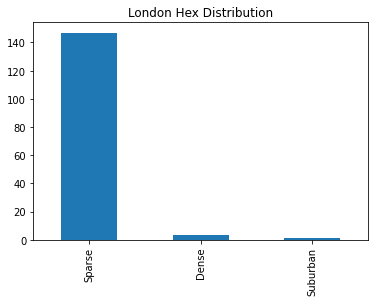

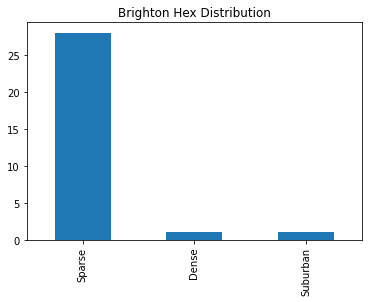

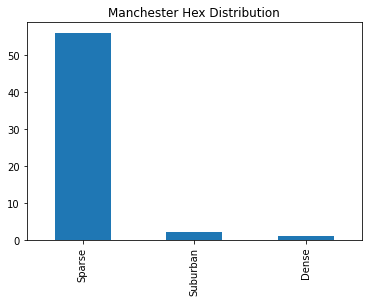

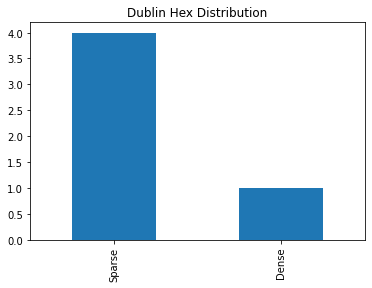

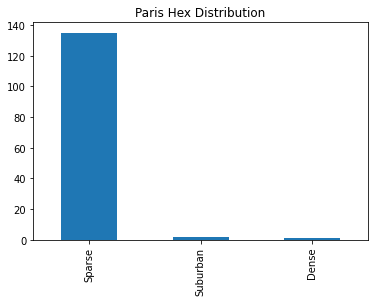

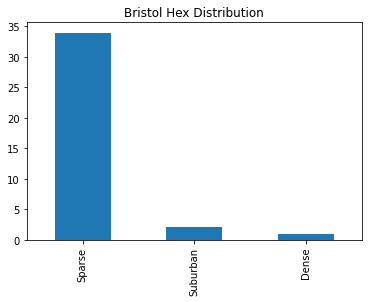

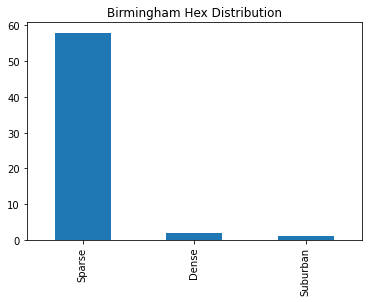

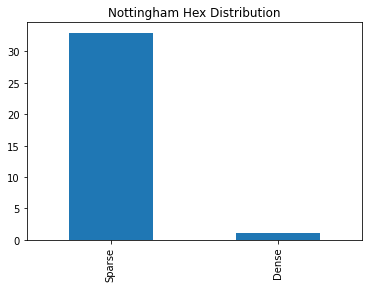

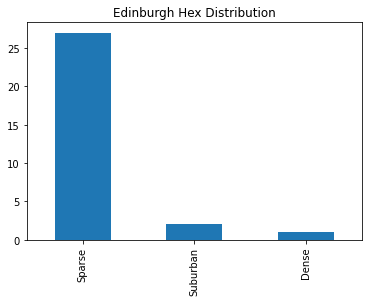

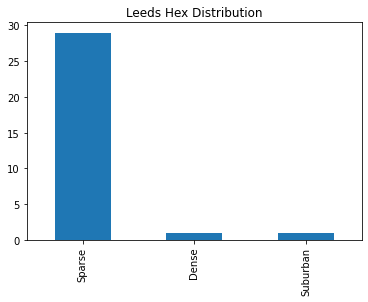

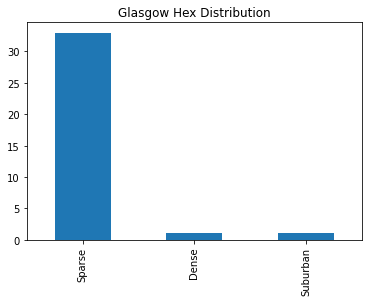

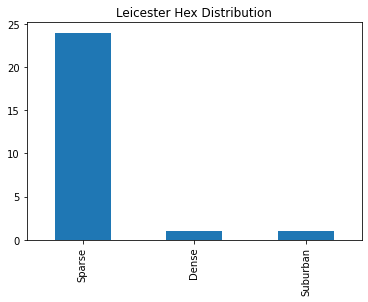

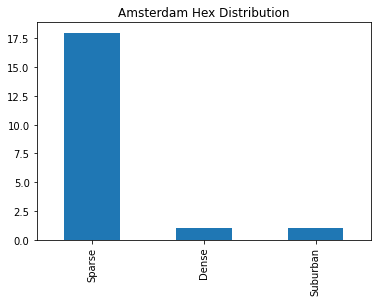

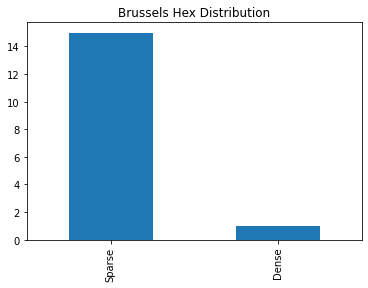

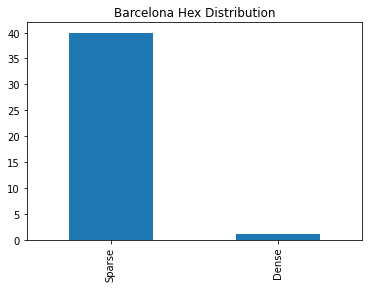

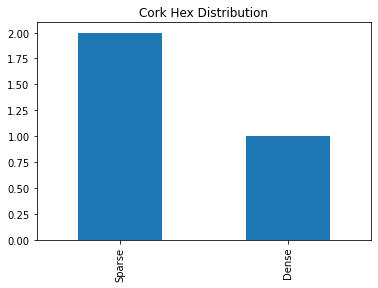

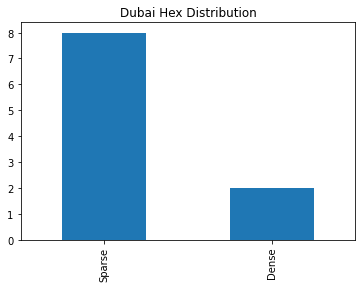

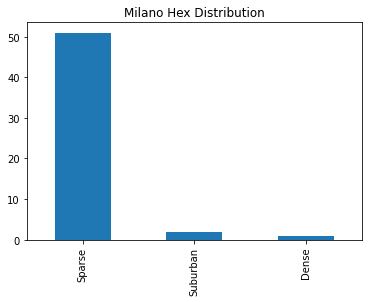

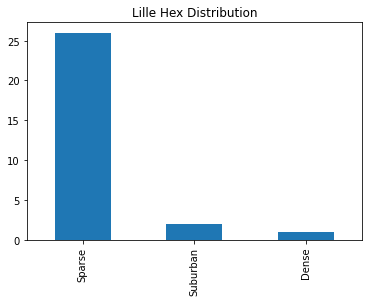

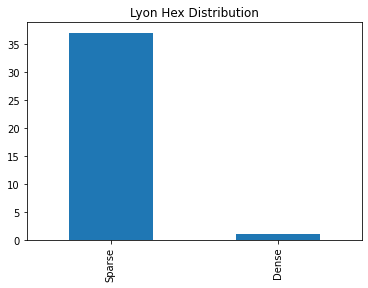

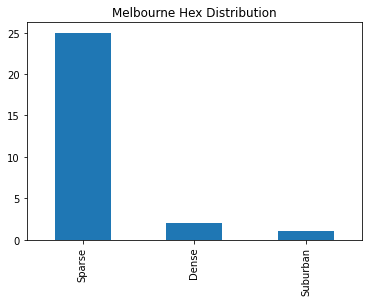

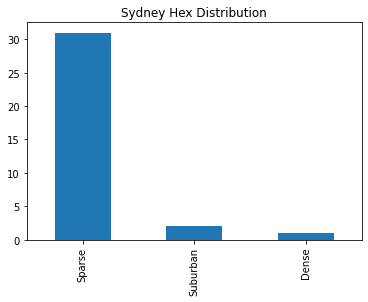

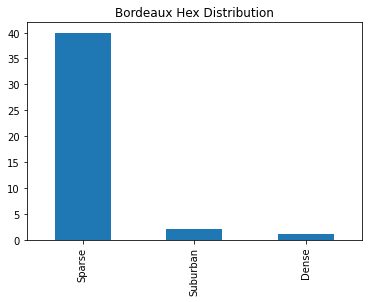

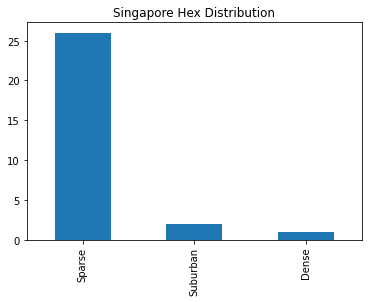

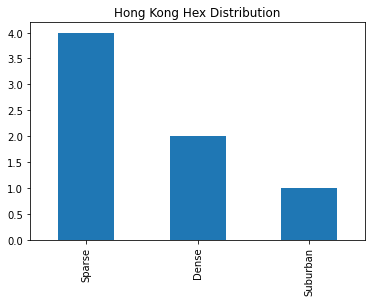

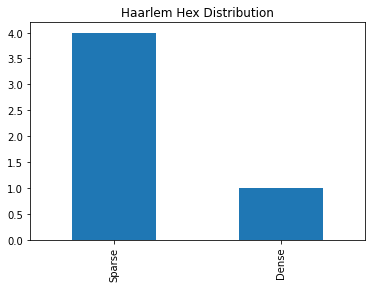

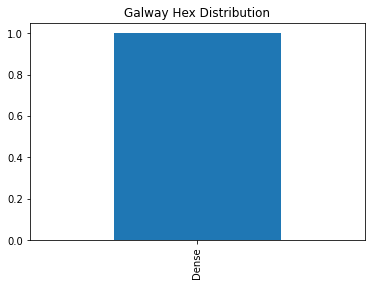

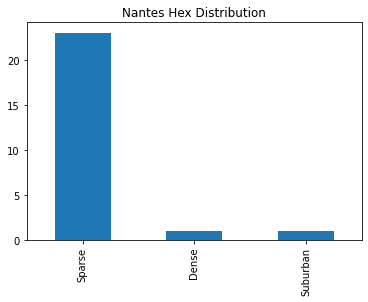

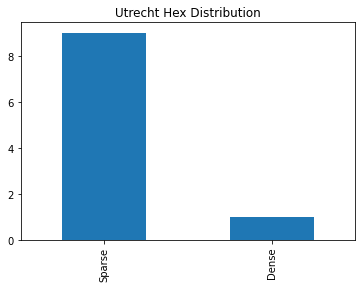

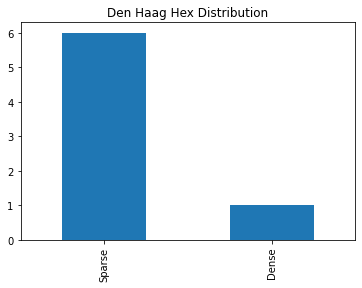

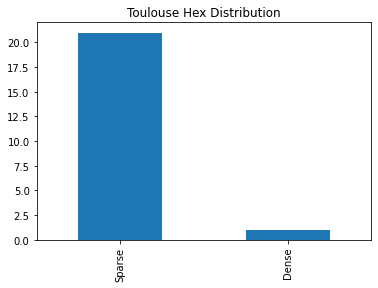

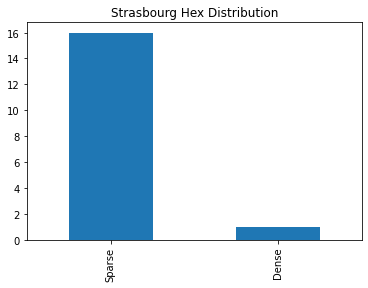

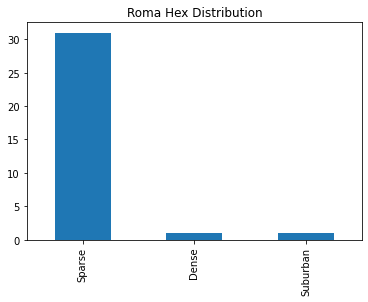

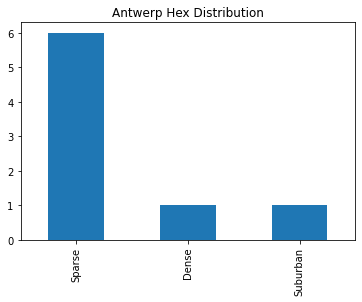

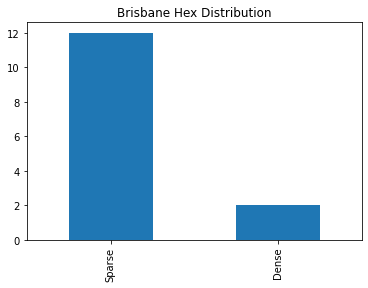

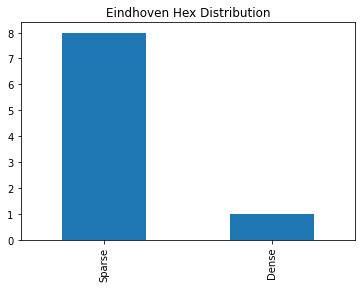

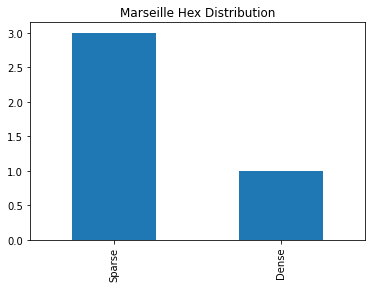

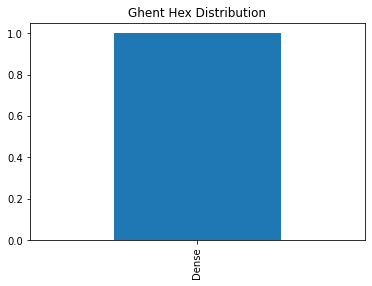

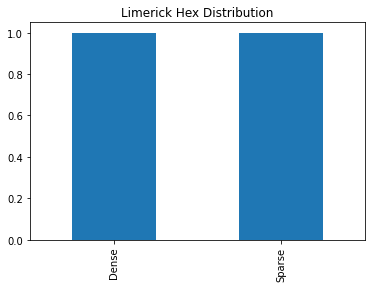

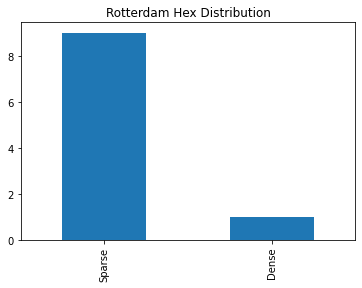

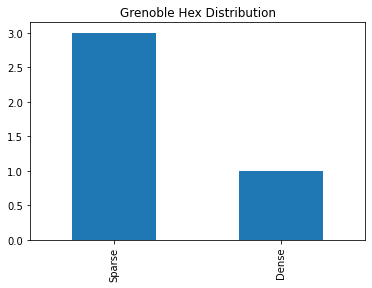

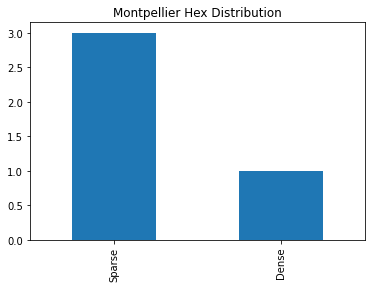

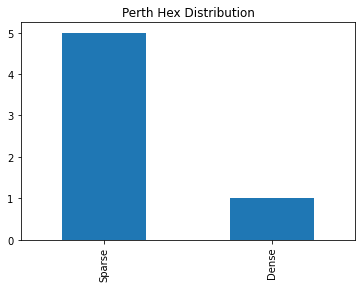

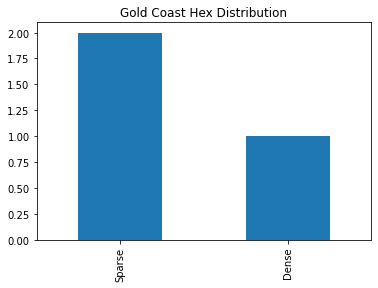

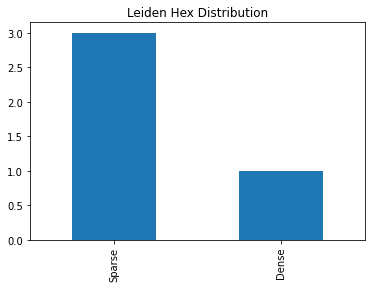

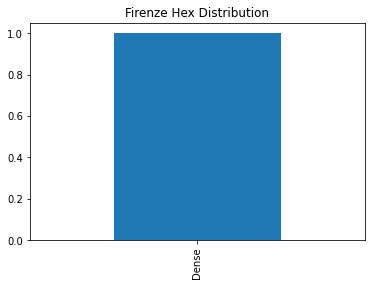

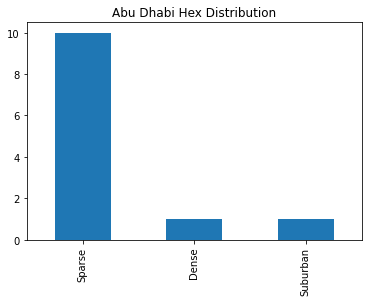

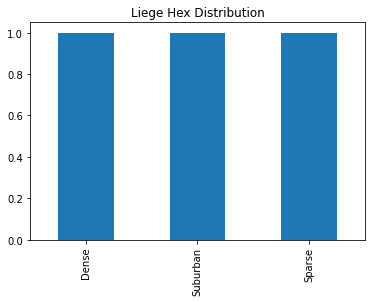

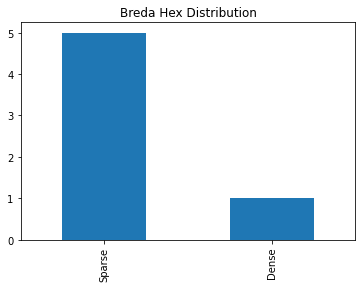

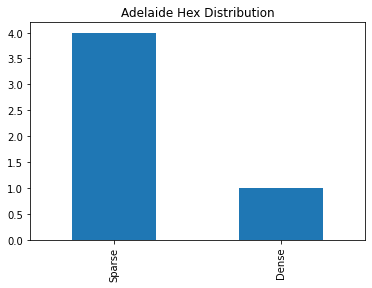

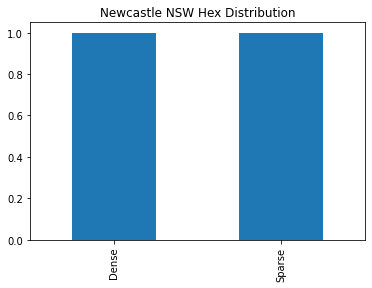

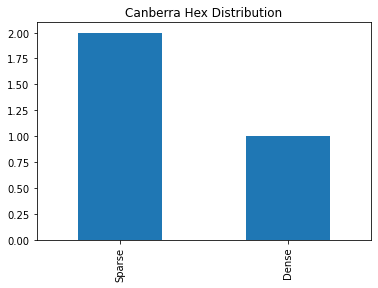

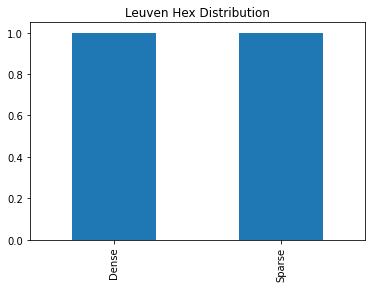

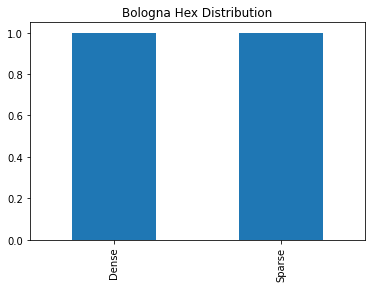

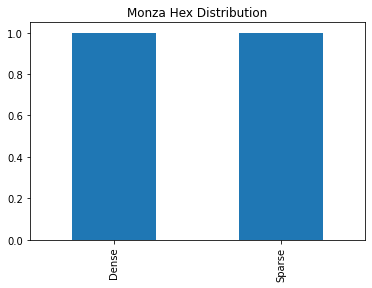

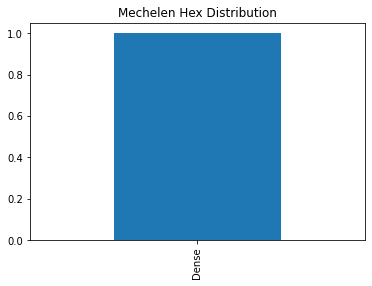

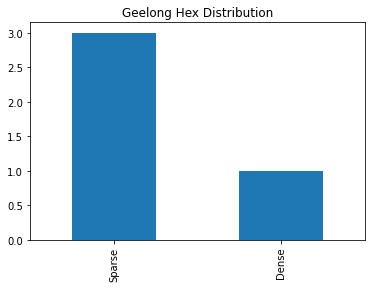

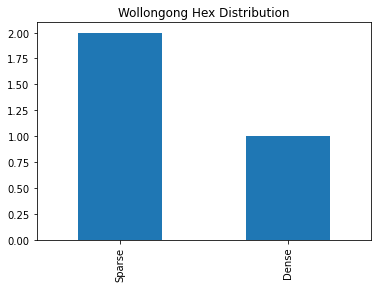

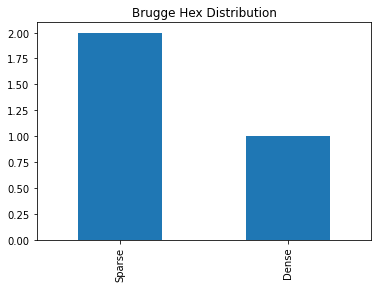

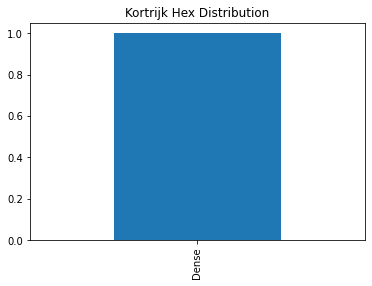

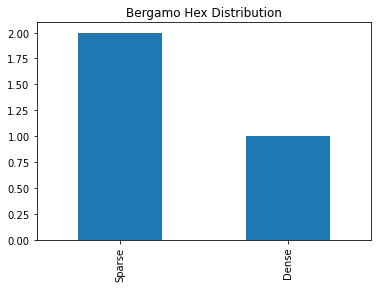

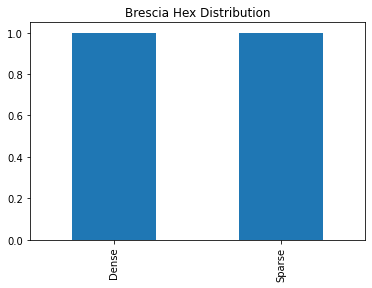

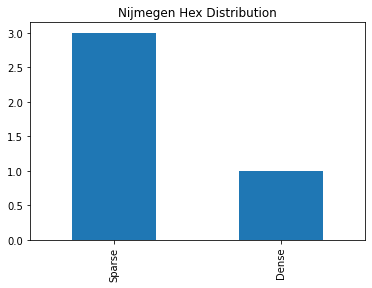

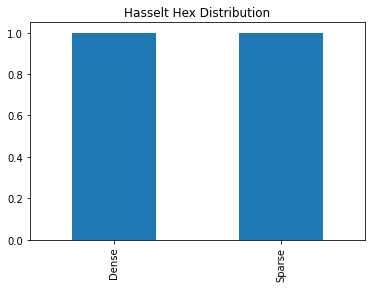

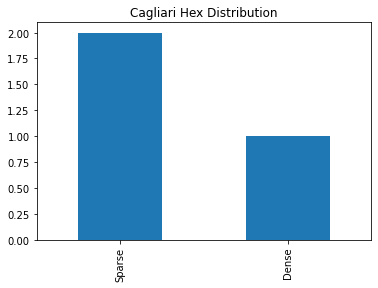

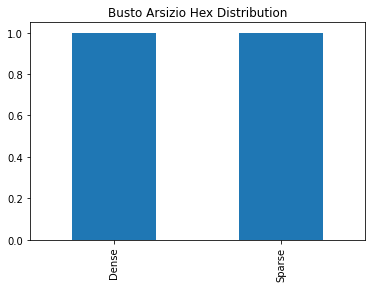

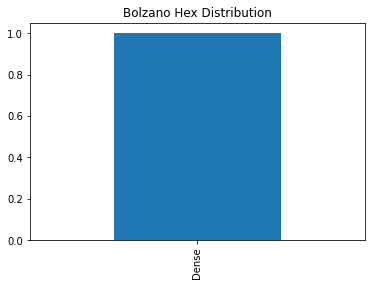

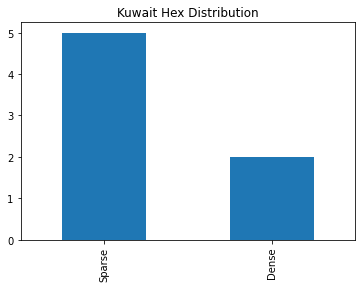

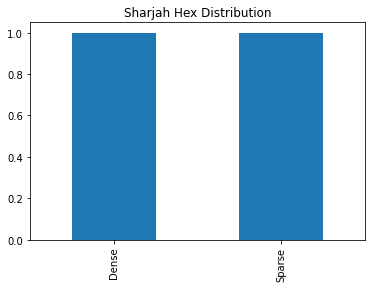

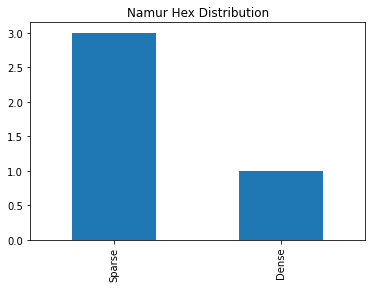

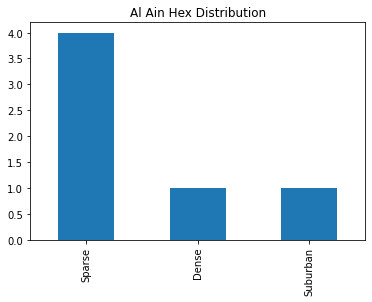

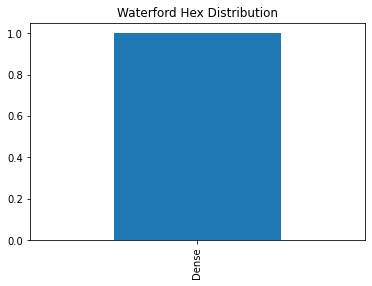

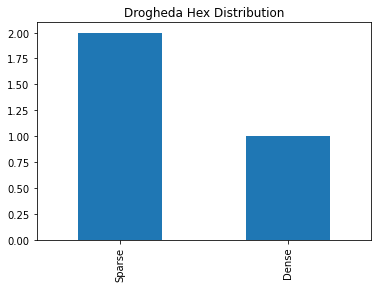

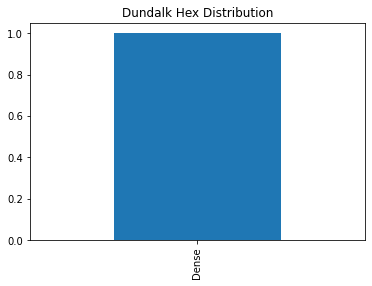

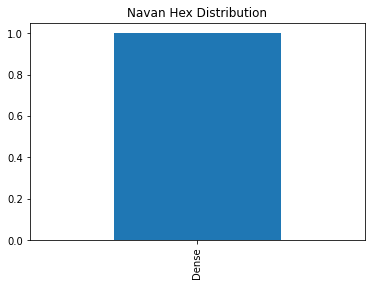

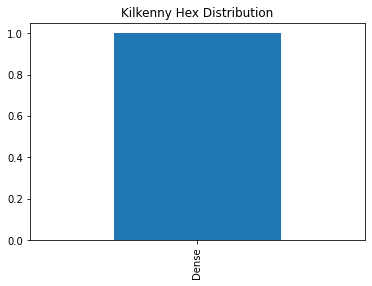

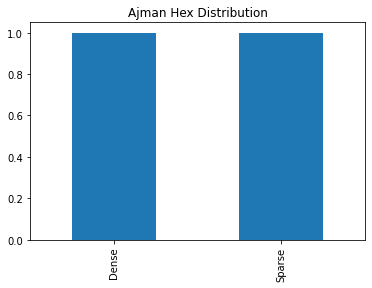

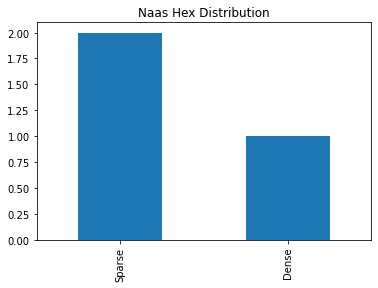

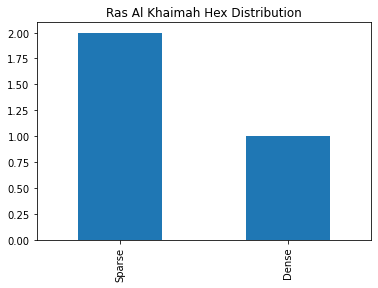

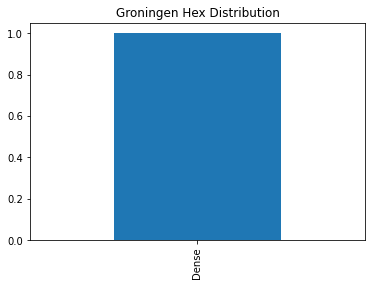

In [38]:
for city in counts['CITY'].unique():
    counts[counts['CITY']==city]['hex_classification'].value_counts().plot(kind='bar')
    plt.title(city+ ' Hex Distribution')
    plt.show()

In [347]:
counts['SPARSE_HEX_PCT'] = counts['SPARSE_HEXES']/counts['TOTAL_HEXES_IN_CITY']
counts['DENSE_HEX_PCT'] = counts['DENSE_HEXES']/counts['TOTAL_HEXES_IN_CITY']
counts['SUBURBAN_HEX_PCT'] = counts['SUBURBAN_HEXES']/counts['TOTAL_HEXES_IN_CITY']
counts['DOWNTOWN_HEX_PCT'] = counts['DOWNTOWN_HEXES']/counts['TOTAL_HEXES_IN_CITY']
counts['SPARSE_CX_PCT'] = counts['SPARSE_CX']/counts['TOTAL_CX_IN_CITY']
counts['DENSE_CX_PCT'] = counts['DENSE_CX']/counts['TOTAL_CX_IN_CITY']
counts['SUBURBAN_CX_PCT'] = counts['SUBURBAN_CX']/counts['TOTAL_CX_IN_CITY']
counts['DOWNTOWN_CX_PCT'] = counts['DOWNTOWN_CX']/counts['TOTAL_CX_IN_CITY']

counts.head()


,CITY_ID,CITY,hex_ID,TOTAL_CUSTOMERS_IN_HEX,AVG_CX_PER_HEX_PER_CITY,cx_classification,RESTAURANT_CITY_ID,RESTAURANT_CITY,TOTAL_RESTAURANTS_IN_HEX,AVG_RX_PER_HEX_PER_CITY,...,DOWNTOWN_CX,TOTAL_CX_IN_CITY,SPARSE_HEX_PCT,DENSE_HEX_PCT,SUBURBAN_HEX_PCT,DOWNTOWN_HEX_PCT,SPARSE_CX_PCT,DENSE_CX_PCT,SUBURBAN_CX_PCT,DOWNTOWN_CX_PCT
0,1.0,London,861825877ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0.0,9302262.0,0.0,0.123989,0.876011,0.0,0.0,0.968493,0.031507,0.0
1,1.0,London,861862807ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0.0,9302262.0,0.0,0.123989,0.876011,0.0,0.0,0.968493,0.031507,0.0
2,1.0,London,861862827ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0.0,9302262.0,0.0,0.123989,0.876011,0.0,0.0,0.968493,0.031507,0.0
3,1.0,London,861870d87ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0.0,9302262.0,0.0,0.123989,0.876011,0.0,0.0,0.968493,0.031507,0.0
4,1.0,London,861874327ffffff,1.0,1.0,High,0.0,0,0.0,0.0,...,0.0,9302262.0,0.0,0.123989,0.876011,0.0,0.0,0.968493,0.031507,0.0


In [348]:
city_classification = ps.sqldf('''SELECT DISTINCT
CITY
,SPARSE_HEX_PCT
,DENSE_HEX_PCT
,SUBURBAN_HEX_PCT
,DOWNTOWN_HEX_PCT
,TOTAL_HEXES_IN_CITY
,SPARSE_CX_PCT
,DENSE_CX_PCT
,SUBURBAN_CX_PCT
,DOWNTOWN_CX_PCT
,TOTAL_CX_IN_CITY

,CASE WHEN SPARSE_HEX_PCT > DENSE_HEX_PCT AND SPARSE_HEX_PCT > SUBURBAN_HEX_PCT AND SPARSE_HEX_PCT > DOWNTOWN_HEX_PCT THEN 'Sparse'
WHEN DENSE_HEX_PCT > SPARSE_HEX_PCT AND DENSE_HEX_PCT > SUBURBAN_HEX_PCT AND DENSE_HEX_PCT > DOWNTOWN_HEX_PCT THEN 'Dense'
WHEN SUBURBAN_HEX_PCT > SPARSE_HEX_PCT AND SUBURBAN_HEX_PCT > DENSE_HEX_PCT AND SUBURBAN_HEX_PCT > DOWNTOWN_HEX_PCT THEN 'Suburban'
WHEN DOWNTOWN_HEX_PCT > SPARSE_HEX_PCT AND DOWNTOWN_HEX_PCT > DENSE_HEX_PCT AND DOWNTOWN_HEX_PCT > SUBURBAN_HEX_PCT THEN 'Downtown'
ELSE NULL
END AS city_classification

,CASE WHEN SPARSE_CX_PCT > DENSE_CX_PCT AND SPARSE_CX_PCT > SUBURBAN_CX_PCT AND SPARSE_CX_PCT > DOWNTOWN_CX_PCT THEN 'Sparse'
WHEN DENSE_CX_PCT > SPARSE_CX_PCT AND DENSE_CX_PCT > SUBURBAN_CX_PCT AND DENSE_CX_PCT > DOWNTOWN_CX_PCT THEN 'Dense'
WHEN SUBURBAN_CX_PCT > SPARSE_CX_PCT AND SUBURBAN_CX_PCT > DENSE_CX_PCT AND SUBURBAN_CX_PCT > DOWNTOWN_CX_PCT THEN 'Suburban'
WHEN DOWNTOWN_CX_PCT > SPARSE_CX_PCT AND DOWNTOWN_CX_PCT > DENSE_CX_PCT AND DOWNTOWN_CX_PCT > SUBURBAN_CX_PCT THEN 'Downtown'
ELSE NULL
END AS cx_classification

FROM counts

''')

city_classification


,CITY,SPARSE_HEX_PCT,DENSE_HEX_PCT,SUBURBAN_HEX_PCT,DOWNTOWN_HEX_PCT,TOTAL_HEXES_IN_CITY,SPARSE_CX_PCT,DENSE_CX_PCT,SUBURBAN_CX_PCT,DOWNTOWN_CX_PCT,TOTAL_CX_IN_CITY,city_classification,cx_classification
0,London,0.000000,0.123989,0.876011,0.0,742,0.000000,0.968493,0.031507,0.0,9302262.0,Suburban,Dense
1,Brighton,0.000000,0.058824,0.941176,0.0,68,0.000000,0.956880,0.043120,0.0,411036.0,Suburban,Dense
2,Manchester,0.000000,0.118557,0.881443,0.0,194,0.000000,0.928557,0.071443,0.0,1350300.0,Suburban,Dense
3,Dublin,0.487179,0.333333,0.179487,0.0,39,0.001236,0.979713,0.019051,0.0,629269.0,Sparse,Dense
4,Paris,0.000000,0.138298,0.861702,0.0,376,0.000000,0.979610,0.020390,0.0,3866716.0,Suburban,Dense
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Ajman,0.444444,0.444444,0.111111,0.0,9,0.042754,0.922113,0.035133,0.0,15484.0,None,Dense
77,Naas,0.444444,0.333333,0.222222,0.0,9,0.046624,0.840032,0.113344,0.0,1244.0,Sparse,Dense
78,Ras Al Khaimah,0.500000,0.350000,0.150000,0.0,20,0.088661,0.707184,0.204155,0.0,8087.0,Sparse,Dense
79,Groningen,0.333333,0.333333,0.333333,0.0,3,0.004505,0.885491,0.110005,0.0,8436.0,None,Dense


In [349]:
# city_classification.to_csv('hex_classification.csv')
# city_classification.to_csv('hex4_median_classification.csv')
# city_classification.to_csv('hex6_median_classification.csv')
# city_classification.to_csv('hex8_classification.csv')
# city_classification.to_csv('hex8_median_classification.csv')
# city_classification.to_csv('hex10_median_classification.csv')
city_classification.to_csv('hex6_median_cx_classification.csv')


# Customer Count, AOV, Spending

In [6]:
# aov and spending

q_cx_features = '''
WITH TMP AS (
SELECT
country_name
,city_name
,count(*) as order_volume
,DENSE_RANK() OVER (ORDER BY order_volume DESC) as rank
FROM production.denormalised.orders
WHERE order_date >= current_date()-61
GROUP BY 1,2
ORDER BY 1,4)

,TMP2 AS (
SELECT
*
FROM TMP
WHERE rank <= 10)

SELECT
user_id
,sum(order_value) as total_order_value_4_week
,count(distinct id) as total_orders_4_week
FROM production.denormalised.orders
WHERE order_date >= current_date() - 30 and city_name in (select city_name from tmp2)
GROUP BY 1
'''

df_cx_features = pd.read_sql(q_cx_features,con)


In [7]:
test = df_cx_geo.merge(df_cx_features[['USER_ID','TOTAL_ORDER_VALUE_4_WEEK','TOTAL_ORDERS_4_WEEK']],how='left', on='USER_ID')
test['AOV'] = test['TOTAL_ORDER_VALUE_4_WEEK']/test['TOTAL_ORDERS_4_WEEK']
test

NameError: name 'df_cx_geo' is not defined

In [20]:
df_hex_classification = ps.sqldf('''SELECT DISTINCT
CITY_ID
,hex_ID
,hex_classification
FROM df_full_classification_final
''')

df_hex_classification


,CITY_ID,hex_ID,hex_classification
0,1.0,861825877ffffff,Suburban
1,1.0,861862807ffffff,Suburban
2,1.0,861862827ffffff,Suburban
3,1.0,861870d87ffffff,Suburban
4,1.0,861874327ffffff,Suburban
...,...,...,...
4279,2541.0,8643acb9fffffff,Sparse
4280,2576.0,86196d857ffffff,Suburban
4281,2576.0,86196d85fffffff,Dense
4282,2576.0,86196d8efffffff,Sparse


In [22]:
t2 = test.merge(df_hex_classification[['CITY_ID','hex_ID','hex_classification']], how='left', on=['CITY_ID','hex_ID'])
t2

,USER_ID,CREATED_AT,CUSTOMER_ZONE_ID,CITY_ID,CITY,GEO_LONG,GEO_LAT,hex_ID,TOTAL_ORDER_VALUE_4_WEEK,TOTAL_ORDERS_4_WEEK,AOV,hex_classification
0,247705,2015-09-25 20:00:06.980692,12.0,1,London,-0.091322,51.501234,86194ad37ffffff,NaN,NaN,NaN,Dense
1,57536106,2021-12-06 04:54:45.099723,273.0,50,Singapore,103.840099,1.319294,866520d97ffffff,NaN,NaN,NaN,Dense
2,19166868,2020-07-15 17:35:14.383844,1156.0,182,Monza,9.275964,45.582857,861f99c5fffffff,NaN,NaN,NaN,Dense
3,9902039,2018-01-17 09:30:47.480750,9.0,1,London,-0.176621,51.534899,86195da4fffffff,NaN,NaN,NaN,Dense
4,17199306,2021-06-21 21:44:12.463069,1882.0,45,Lyon,4.806640,45.693017,861f902e7ffffff,NaN,NaN,NaN,Dense
...,...,...,...,...,...,...,...,...,...,...,...,...
36025187,61023683,2022-01-23 07:39:03.212433,194.0,40,Dubai,55.177893,25.100876,8643a130fffffff,278.5,7.0,39.785714,Dense
36025188,19501895,2022-01-23 11:58:43.383259,43.0,11,Birmingham,-1.897073,52.473187,86195c05fffffff,34.1,2.0,17.050000,Dense
36025189,27960414,2020-02-17 04:17:05.065827,857.0,51,Hong Kong,114.136283,22.342735,86411cb37ffffff,433.0,3.0,144.333333,Dense
36025190,17094254,2019-02-10 20:53:01.581662,NaN,9,Bristol,-2.623973,51.476959,861958767ffffff,NaN,NaN,NaN,Dense


In [ ]:
hex_classification_aov = ps.sqldf('''SELECT
city
,city_id
,hex_classification
,AVG(AOV) AS HEX_AOV
FROM t2
WHERE TOTAL_ORDER_VALUE_4_WEEK >= 0
GROUP BY 1,2,3
ORDER BY 1,2,3
''')

hex_classification_aov.head()

In [53]:
counts_2 = counts.merge(cx_orders, how='left', on=['hex_ID','CITY_ID'])
counts_2

In [66]:
q_order_locations = '''SELECT
user_id
,id
,restaurant_city_id
,customer_city_id
,RESTAURANT_GEO_LAT
,RESTAURANT_GEO_LONG
,CUSTOMER_GEO_LAT
,CUSTOMER_GEO_LONG
,TOTAL_VALUE * EXCHANGE_RATE AS TOTAL_VALUE_GBP
FROM production.denormalised.orders
WHERE order_date >= current_date() - 30
AND business_unit_name in ('London','Paris')

'''

order_locations = pd.read_sql(q_order_locations,con)


In [274]:
lst3=[]
lst4=[]

for i in range(order_locations.shape[0]):
    hex3=0
    hex3 = h3.geo_to_h3(order_locations['RESTAURANT_GEO_LAT'][i],order_locations['RESTAURANT_GEO_LONG'][i], resolution=10)
    hex4=0
    hex4 = h3.geo_to_h3(order_locations['CUSTOMER_GEO_LAT'][i],order_locations['CUSTOMER_GEO_LONG'][i], resolution=10)
    lst3.append(hex3)
    lst4.append(hex4)
order_locations['rx_hex_ID'] = lst3
order_locations['cx_hex_ID'] = lst4

In [275]:
order_locations2 = ps.sqldf('''SELECT
*
,CASE WHEN rx_hex_ID = cx_hex_ID THEN 1 ELSE 0 END AS SAME_HEX_ORDER
,CASE WHEN rx_hex_ID != cx_hex_ID THEN 1 ELSE 0 END AS OUT_OF_HEX_ORDER
FROM order_locations
''')

order_locations

,ID,RESTAURANT_CITY_ID,CUSTOMER_CITY_ID,RESTAURANT_GEO_LAT,RESTAURANT_GEO_LONG,CUSTOMER_GEO_LAT,CUSTOMER_GEO_LONG,rx_hex_ID,cx_hex_ID,SAME_HEX_ORDER,OUT_OF_HEX_ORDER
0,881949684,1,1.0,51.493677,-0.073976,51.477676,-0.076658,8a194ad33b2ffff,8a194ad0655ffff,1,0
1,881327838,1,1.0,51.487508,0.283961,51.474380,0.306161,8a194e652767fff,8a194e653007fff,1,0
2,882799041,1,1.0,51.559520,-0.007876,51.560941,-0.002798,8a194e69c2cffff,8a194e69c247fff,1,0
3,882575230,1,1.0,51.539808,-0.142468,51.547246,-0.189032,8a195da4c367fff,8a195da4e197fff,1,0
4,881969169,1,1.0,51.524089,-0.071742,51.516519,-0.073145,8a194ad34647fff,8a194ad308d7fff,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7279818,893641876,1,1.0,51.540501,-0.057553,51.563139,-0.058036,8a194ad34917fff,8a195da6da6ffff,1,0
7279819,893502438,1,1.0,51.671973,-0.396876,51.654277,-0.423178,8a195da18c2ffff,8a195da1a2e7fff,1,0
7279820,894768067,1,1.0,51.494393,-0.173534,51.488299,-0.137642,8a194ada594ffff,8a194ad16b47fff,1,0
7279821,895117749,1,1.0,51.530466,-0.121370,51.539106,-0.102616,8a195da4dbb7fff,8a194ad36c37fff,0,1


In [276]:
rx_hex_orders = ps.sqldf('''SELECT
RESTAURANT_CITY_ID
,rx_hex_ID
,SUM(SAME_HEX_ORDER) AS SAME_HEX_ORDERS
,SUM(OUT_OF_HEX_ORDER) AS OUT_OF_HEX_ORDERS
,COUNT(SAME_HEX_ORDER) AS TOTAL_ORDERS
FROM order_locations2
GROUP BY 1,2
''')

rx_hex_orders['SAME_ORDER_PCT'] = rx_hex_orders['SAME_HEX_ORDERS']/rx_hex_orders['TOTAL_ORDERS']
rx_hex_orders['OUT_ORDER_PCT'] = rx_hex_orders['OUT_OF_HEX_ORDERS']/rx_hex_orders['TOTAL_ORDERS']

rx_hex_orders.head()


,RESTAURANT_CITY_ID,rx_hex_ID,SAME_HEX_ORDERS,OUT_OF_HEX_ORDERS,TOTAL_ORDERS,SAME_ORDER_PCT,OUT_ORDER_PCT
0,1,8a194a5120a7fff,0,12,12,0.000000,1.000000
1,1,8a194a51219ffff,0,10,10,0.000000,1.000000
2,1,8a194a5854b7fff,1,287,288,0.003472,0.996528
3,1,8a194a585607fff,0,1,1,0.000000,1.000000
4,1,8a194a5a02dffff,2,310,312,0.006410,0.993590


/Users/elliotsafo/.local/share/virtualenvs/ESPythonProject-PeGlDRVf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


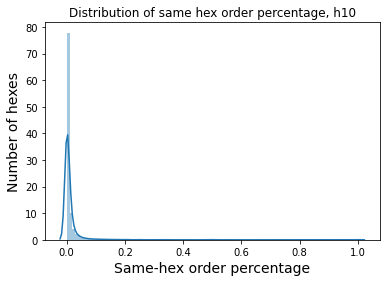

In [277]:
sns.distplot(x=rx_hex_orders['SAME_ORDER_PCT'],bins=100)
plt.title('Distribution of same hex order percentage, h10')
plt.xlabel('Same-hex order percentage', fontsize=14)
plt.ylabel('Number of hexes', fontsize=14)

plt.show()



# Sparsity in terms of orders

In [2]:
q_orders = '''

SELECT
id
,business_unit_name
,restaurant_city_id
,restaurant_city_name
,customer_city_id
,customer_city_name
,RESTAURANT_GEO_LAT
,RESTAURANT_GEO_LONG
,CUSTOMER_GEO_LAT
,CUSTOMER_GEO_LONG
,rider_experience_time
FROM production.denormalised.orders
WHERE order_date >= current_date() - 30
AND customer_city_name in ('Hong Kong'
,'Dublin'
,'Milano'
,'Kuwait'
,'London'
,'Paris'
,'Birmingham'
,'Manchester'
,'Singapore'
,'Dubai')

'''

orders = pd.read_sql(q_orders,con)



In [29]:
# lst3=[]
lst4=[]

for i in range(orders.shape[0]):
#     hex3=0
#     hex3 = h3.geo_to_h3(orders['RESTAURANT_GEO_LAT'][i],orders['RESTAURANT_GEO_LONG'][i], resolution=6)
    hex4=0
    hex4 = h3.geo_to_h3(orders['CUSTOMER_GEO_LAT'][i],orders['CUSTOMER_GEO_LONG'][i], resolution=10)
#     lst3.append(hex3)
    lst4.append(hex4)
# orders['rx_hex_ID'] = lst3
orders['cx_hex_ID'] = lst4


In [30]:
order_sparsity = ps.sqldf('''SELECT
cx_hex_ID
,business_unit_name
,CUSTOMER_CITY_ID
,CUSTOMER_CITY_NAME
,COUNT(distinct id) as order_volume
FROM orders
GROUP BY 1,2,3,4''')

order_sparsity


,cx_hex_ID,BUSINESS_UNIT_NAME,CUSTOMER_CITY_ID,CUSTOMER_CITY_NAME,order_volume
0,8a182c02000ffff,Ireland,5,Dublin,4
1,8a182c02004ffff,Ireland,5,Dublin,4
2,8a182c02005ffff,Ireland,5,Dublin,4
3,8a182c02006ffff,Ireland,5,Dublin,31
4,8a182c0200c7fff,Ireland,5,Dublin,1
...,...,...,...,...,...
378262,8a6526adec37fff,Singapore,50,Singapore,2
378263,8a6526adec47fff,Singapore,50,Singapore,2
378264,8a6526adecc7fff,Singapore,50,Singapore,2
378265,8a6526adeceffff,Singapore,50,Singapore,3


In [31]:
city_sparsity = ps.sqldf('''SELECT
BUSINESS_UNIT_NAME
,CUSTOMER_CITY_NAME
,SUM(CASE WHEN order_volume < 100 THEN 1 ELSE 0 END) AS sparse_hexes
,COUNT(cx_hex_ID) AS total_hexes
FROM order_sparsity
GROUP BY 1,2
ORDER BY 1,2
''')


city_sparsity['data_sparsity'] = city_sparsity['sparse_hexes']/city_sparsity['total_hexes']
city_sparsity

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,sparse_hexes,total_hexes,data_sparsity
0,Hong Kong,Hong Kong,5680,9876,0.575132
1,Ireland,Dublin,12709,13997,0.907980
2,Italy,Milano,21521,23222,0.926750
3,Kuwait,Kuwait,18481,20315,0.909722
4,London,London,122423,139115,0.880013
5,Paris,Paris,57759,65748,0.878491
6,RFR,Paris,3,3,1.000000
7,RUK,Birmingham,33143,33576,0.987104
8,RUK,London,73,74,0.986486
9,RUK,Manchester,32872,33851,0.971079


In [251]:
# city_sparsity.to_csv('hex4_city_sparsity.csv')
# city_sparsity.to_csv('hex6_city_sparsity.csv')
# city_sparsity.to_csv('hex8_city_sparsity.csv')
city_sparsity.to_csv('hex10_city_sparsity.csv')


# AOV Precision

In [8]:
q_aov = '''

SELECT
a.user_id
,a.id
,a.business_unit_name
,a.restaurant_city_id
,a.restaurant_city_name
,a.customer_city_id
,a.customer_city_name
,a.RESTAURANT_GEO_LAT
,a.RESTAURANT_GEO_LONG
,a.CUSTOMER_GEO_LAT
,a.CUSTOMER_GEO_LONG
,a.TOTAL_VALUE * EXCHANGE_RATE AS TOTAL_VALUE_GBP
FROM production.denormalised.orders a
WHERE order_date >= current_date() - 30
AND customer_city_name in ('Hong Kong'
,'Dublin'
,'Milano'
,'Kuwait'
,'London'
,'Paris'
,'Birmingham'
,'Manchester'
,'Singapore'
,'Dubai')

'''


aov = pd.read_sql(q_aov,con)

In [283]:
aov.head()

,USER_ID,ID,BUSINESS_UNIT_NAME,RESTAURANT_CITY_ID,RESTAURANT_CITY_NAME,CUSTOMER_CITY_ID,CUSTOMER_CITY_NAME,RESTAURANT_GEO_LAT,RESTAURANT_GEO_LONG,CUSTOMER_GEO_LAT,CUSTOMER_GEO_LONG,TOTAL_VALUE_GBP
0,10622815,900527591,London,1,London,1,London,51.483908,-0.055838,51.501806,-0.045711,19.210
1,27961035,895998060,Hong Kong,51,Hong Kong,51,Hong Kong,22.277734,114.177212,22.278173,114.177010,10.479
2,61787294,898553175,RUK,3,Manchester,3,Manchester,53.531994,-2.427200,53.507384,-2.433783,23.010
3,31706900,898032233,London,1,London,1,London,51.583527,-0.022439,51.590057,-0.035172,14.560
4,36435587,900897140,RUK,3,Manchester,3,Manchester,53.537828,-2.127158,53.549767,-2.163398,8.090


In [32]:
lst5=[]
lst6=[]

for i in range(aov.shape[0]):
#     hex5=0
#     hex5 = h3.geo_to_h3(aov['RESTAURANT_GEO_LAT'][i],aov['RESTAURANT_GEO_LONG'][i], resolution=6)
    hex6=0
    hex6 = h3.geo_to_h3(aov['CUSTOMER_GEO_LAT'][i],aov['CUSTOMER_GEO_LONG'][i], resolution=10)
#     lst5.append(hex5)
    lst6.append(hex6)
# aov['rx_hex_ID'] = lst5
aov['cx_hex_ID'] = lst6

In [301]:
cx_aov = aov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID','USER_ID'])['TOTAL_VALUE_GBP'].mean().to_frame().reset_index()
cx_aov

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,cx_hex_ID,USER_ID,TOTAL_VALUE_GBP
0,Hong Kong,Hong Kong,8a4103482007fff,2042723,53.792200
1,Hong Kong,Hong Kong,8a4103482007fff,3608158,80.738200
2,Hong Kong,Hong Kong,8a4103482007fff,22631451,32.709450
3,Hong Kong,Hong Kong,8a4103482007fff,35440034,39.452366
4,Hong Kong,Hong Kong,8a4103482017fff,918397,66.217300
...,...,...,...,...,...
5040509,United Arab Emirates,Dubai,8a43acd9eccffff,7886971,20.070464
5040510,United Arab Emirates,Dubai,8a43acd9eccffff,21854472,26.709880
5040511,United Arab Emirates,Dubai,8a43acd9ecdffff,10336244,23.002000
5040512,United Arab Emirates,Dubai,8a43acd9ecdffff,44203913,26.937780


In [302]:
hex_aov_means = cx_aov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])['TOTAL_VALUE_GBP'].mean().to_frame().reset_index().rename(columns={'TOTAL_VALUE_GBP':'MEAN_AOV'})
hex_aov_std = cx_aov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])['TOTAL_VALUE_GBP'].std().to_frame().reset_index().rename(columns={'TOTAL_VALUE_GBP':'STD_AOV'})

hex_aov_cov = hex_aov_means.merge(hex_aov_std, how='left', on=['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])
hex_aov_cov['COEFF_OF_VARIATION'] = hex_aov_cov['STD_AOV']/hex_aov_cov['MEAN_AOV']

hex_aov_cov

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,cx_hex_ID,MEAN_AOV,STD_AOV,COEFF_OF_VARIATION
0,Hong Kong,Hong Kong,8a4103482007fff,51.673054,21.277821,0.411778
1,Hong Kong,Hong Kong,8a4103482017fff,57.996275,31.299047,0.539673
2,Hong Kong,Hong Kong,8a410348201ffff,101.756080,NaN,NaN
3,Hong Kong,Hong Kong,8a4103482037fff,55.980038,30.585122,0.546358
4,Hong Kong,Hong Kong,8a4103482087fff,33.261474,15.086923,0.453586
...,...,...,...,...,...,...
374655,United Arab Emirates,Dubai,8a43acd9ec6ffff,36.012751,34.187767,0.949324
374656,United Arab Emirates,Dubai,8a43acd9ecc7fff,38.881860,26.397060,0.678904
374657,United Arab Emirates,Dubai,8a43acd9eccffff,23.390172,4.694776,0.200716
374658,United Arab Emirates,Dubai,8a43acd9ecdffff,24.969890,2.783017,0.111455


In [ ]:
# hex_cov_order = hex_aov_cov.merge(order_sparsity[['CUSTOMER_CITY_NAME','cx_hex_ID','order_volume']], how='left', on=['CUSTOMER_CITY_NAME','cx_hex_ID'])

In [303]:
precision_tmp = hex_aov_cov.groupby('CUSTOMER_CITY_NAME')['COEFF_OF_VARIATION'].median().to_frame().reset_index().rename(columns={'COEFF_OF_VARIATION':'precision'})
precision_tmp.head()

,CUSTOMER_CITY_NAME,precision
0,Birmingham,0.381367
1,Dubai,0.504020
2,Dublin,0.402859
3,Hong Kong,0.613484
4,Kuwait,0.489273


In [304]:
precision = city_sparsity.merge(precision_tmp, how='left', on='CUSTOMER_CITY_NAME')
precision.to_csv('sparsity_precision_h10.csv')
precision

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,sparse_hexes,total_hexes,data_sparsity,precision
0,Hong Kong,Hong Kong,5699,9905,0.575366,0.613484
1,Ireland,Dublin,12321,13548,0.909433,0.402859
2,Italy,Milano,21562,23229,0.928236,0.431040
3,Kuwait,Kuwait,18427,20319,0.906885,0.489273
4,London,London,121374,137455,0.883009,0.420759
5,Paris,Paris,57679,65689,0.878062,0.416317
6,RFR,Paris,2,2,1.000000,0.416317
7,RUK,Birmingham,32555,32959,0.987742,0.381367
8,RUK,London,8,8,1.000000,0.420759
9,RUK,Manchester,32438,33355,0.972508,0.402095


In [5]:
sparsityvprecision = pd.read_csv('sparsityvprecision.csv')
sparsityvprecision



,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,sparse_hexes,total_hexes,data_sparsity h6,1/precision h6,precision h6,data_sparsity h8,1/precision h8,precision h8,data_sparsity 10,1/precision 10,precision 10
0,Hong Kong,Hong Kong,1,33,0.030303,0.720775,1.387396,0.205882,0.718189,1.392391,0.575366,0.613484,1.630033
1,Ireland,Dublin,14,35,0.400000,0.477300,2.095120,0.539230,0.465244,2.149411,0.909433,0.402859,2.482259
2,Italy,Milano,17,60,0.283333,0.492607,2.030016,0.550209,0.482209,2.073788,0.928236,0.431040,2.319972
3,Kuwait,Kuwait,20,50,0.400000,0.655189,1.526278,0.357143,0.618026,1.618056,0.906885,0.489273,2.043848
4,London,London,22,209,0.105263,0.514161,1.944914,0.458352,0.486636,2.054925,0.883009,0.420759,2.376659
5,Paris,Paris,31,121,0.256198,0.496512,2.014051,0.465000,0.473826,2.110481,0.878062,0.416317,2.402016
6,RFR,Paris,2,2,1.000000,0.496512,2.014051,1.000000,0.473826,2.110481,1.000000,0.416317,2.402016
7,RUK,Birmingham,8,48,0.166667,0.507155,1.971783,0.387283,0.473276,2.112932,0.987742,0.381367,2.622147
8,RUK,London,8,8,1.000000,0.514161,1.944914,1.000000,0.486636,2.054925,1.000000,0.420759,2.376659
9,RUK,Manchester,4,51,0.078431,0.502879,1.988549,0.359010,0.483067,2.070106,0.972508,0.402095,2.486974


# OV Precision

In [33]:
ov = aov

In [283]:
lst7=[]
lst8=[]
lst9=[]

for i in range(ov.shape[0]):
    hex7=0
    hex7 = h3.geo_to_h3(ov['CUSTOMER_GEO_LAT'][i],ov['CUSTOMER_GEO_LONG'][i], resolution=6)
    hex8=0
    hex8 = h3.geo_to_h3(ov['CUSTOMER_GEO_LAT'][i],ov['CUSTOMER_GEO_LONG'][i], resolution=8)
    hex9=0
    hex9 = h3.geo_to_h3(ov['CUSTOMER_GEO_LAT'][i],ov['CUSTOMER_GEO_LONG'][i], resolution=10)
    lst7.append(hex7)
    lst8.append(hex8)
    lst9.append(hex9)
ov['cx_hex6'] = lst7
ov['cx_hex8'] = lst8
ov['cx_hex10'] = lst9

In [34]:
cx_ov6 = ov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID','USER_ID'])['ID'].count().to_frame().reset_index()
# cx_ov8 = ov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex8'])['ID'].count().to_frame().reset_index()
# cx_ov10 = ov.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex10'])['ID'].count().to_frame().reset_index()

# cx_ov_tmp = cx_ov6.merge(cx_ov8, how='left', on=['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME'])

In [35]:
cx_ov6.head()

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,cx_hex_ID,USER_ID,ID
0,Hong Kong,Hong Kong,8a4103482007fff,3608158,1
1,Hong Kong,Hong Kong,8a4103482007fff,35440034,13
2,Hong Kong,Hong Kong,8a4103482007fff,38284009,1
3,Hong Kong,Hong Kong,8a4103482017fff,918397,3
4,Hong Kong,Hong Kong,8a4103482017fff,983149,2


In [36]:
hex_ov_means = cx_ov6.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])['ID'].mean().to_frame().reset_index().rename(columns={'ID':'MEAN_OV'})
hex_ov_std = cx_ov6.groupby(['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])['ID'].std().to_frame().reset_index().rename(columns={'ID':'STD_OV'})

hex_ov_cov = hex_ov_means.merge(hex_ov_std, how='left', on=['BUSINESS_UNIT_NAME','CUSTOMER_CITY_NAME','cx_hex_ID'])
hex_ov_cov['COEFF_OF_VARIATION'] = hex_ov_cov['STD_OV']/hex_ov_cov['MEAN_OV']

hex_ov_cov

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,cx_hex_ID,MEAN_OV,STD_OV,COEFF_OF_VARIATION
0,Hong Kong,Hong Kong,8a4103482007fff,5.000000,6.928203,1.385641
1,Hong Kong,Hong Kong,8a4103482017fff,1.750000,0.957427,0.547101
2,Hong Kong,Hong Kong,8a410348201ffff,2.000000,1.414214,0.707107
3,Hong Kong,Hong Kong,8a4103482037fff,1.428571,0.786796,0.550757
4,Hong Kong,Hong Kong,8a4103482087fff,4.080000,3.616167,0.886316
...,...,...,...,...,...,...
378262,United Arab Emirates,Dubai,8a43acd9ec57fff,7.666667,10.692677,1.394697
378263,United Arab Emirates,Dubai,8a43acd9ec6ffff,6.681818,7.479409,1.119367
378264,United Arab Emirates,Dubai,8a43acd9ecc7fff,1.000000,NaN,NaN
378265,United Arab Emirates,Dubai,8a43acd9ecdffff,1.500000,0.707107,0.471405


In [37]:
precision_ov_tmp = hex_ov_cov.groupby('CUSTOMER_CITY_NAME')['COEFF_OF_VARIATION'].median().to_frame().reset_index().rename(columns={'COEFF_OF_VARIATION':'AGG_ERROR'})
precision_ov_tmp.head()

,CUSTOMER_CITY_NAME,AGG_ERROR
0,Birmingham,0.666667
1,Dubai,0.908511
2,Dublin,0.768877
3,Hong Kong,1.092369
4,Kuwait,0.896938


In [38]:
precision = city_sparsity.merge(precision_ov_tmp, how='left', on='CUSTOMER_CITY_NAME')
precision.to_csv('sparsity_precision_ov_h10.csv')
precision

,BUSINESS_UNIT_NAME,CUSTOMER_CITY_NAME,sparse_hexes,total_hexes,data_sparsity,AGG_ERROR
0,Hong Kong,Hong Kong,5680,9876,0.575132,1.092369
1,Ireland,Dublin,12709,13997,0.907980,0.768877
2,Italy,Milano,21521,23222,0.926750,0.692820
3,Kuwait,Kuwait,18481,20315,0.909722,0.896938
4,London,London,122423,139115,0.880013,0.857143
5,Paris,Paris,57759,65748,0.878491,0.844141
6,RFR,Paris,3,3,1.000000,0.844141
7,RUK,Birmingham,33143,33576,0.987104,0.666667
8,RUK,London,73,74,0.986486,0.857143
9,RUK,Manchester,32872,33851,0.971079,0.707107


In [40]:
city_charts = pd.read_csv('city_s_p_3.csv')
city_charts

,city,hex resolution,data sparsity,agg error
0,Hong Kong,H6,0.030303,1.303958
1,Hong Kong,H8,0.209644,1.262985
2,Hong Kong,H10,0.575132,1.092369
3,Dublin,H6,0.388889,1.090179
4,Dublin,H8,0.530070,1.010153
5,Dublin,H10,0.907980,0.768877
6,Milano,H6,0.266667,1.032173
7,Milano,H8,0.551291,0.906726
8,Milano,H10,0.926750,0.692820
9,Kuwait,H6,0.420000,1.304366


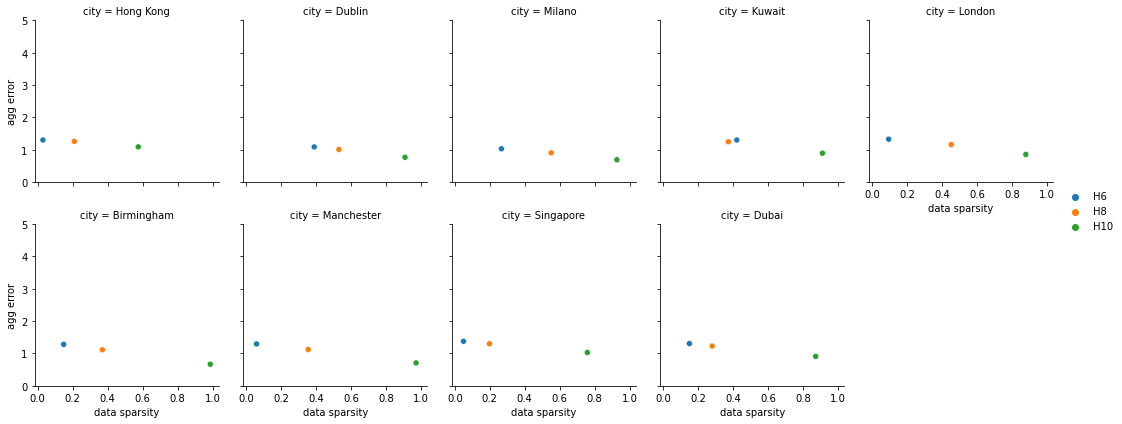

In [47]:
g = sns.FacetGrid(city_charts[(city_charts['city']!='Paris')], col="city", col_wrap=5)
g.map_dataframe(sns.scatterplot, x="data sparsity", y="agg error", hue="hex resolution")
# g.refline(y=0, linestyle=":")
g.set(ylim=(0, 5))
g.add_legend()

# CLV Precision

In [6]:
q_clv = '''WITH TMP AS (
SELECT
country_name
,city_name
,count(*) as order_volume
,DENSE_RANK() OVER (ORDER BY order_volume DESC) as rank
FROM production.denormalised.orders
WHERE order_date >= current_date()-21
GROUP BY 1,2
ORDER BY 1,4)

,TMP2 AS (
SELECT
*
FROM TMP
WHERE rank <= 10
order by rank)

SELECT
a.user_id
,a.id
,a.business_unit_name
,a.restaurant_city_id
,a.restaurant_city_name
,a.customer_city_id
,a.customer_city_name
,a.RESTAURANT_GEO_LAT
,a.RESTAURANT_GEO_LONG
,a.CUSTOMER_GEO_LAT
,a.CUSTOMER_GEO_LONG
,b.pcp*b.exchange_rate as partial_contribution_profit
FROM production.denormalised.orders a
LEFT JOIN production.finance.gross_profit b
ON a.id = b.order_id
WHERE a.order_date >= current_date() - 30
AND a.customer_city_name in (SELECT city_name FROM TMP2)

'''


clv = pd.read_sql(q_clv,con)

In [23]:
lst7=[]
lst8=[]

for i in range(clv.shape[0]):
    hex7=0
    hex7 = h3.geo_to_h3(clv['RESTAURANT_GEO_LAT'][i],clv['RESTAURANT_GEO_LONG'][i], resolution=10)
    hex8=0
    hex8 = h3.geo_to_h3(clv['CUSTOMER_GEO_LAT'][i],clv['CUSTOMER_GEO_LONG'][i], resolution=10)
    lst7.append(hex7)
    lst8.append(hex8)
clv['rx_hex_ID'] = lst7
clv['cx_hex_ID'] = lst8

In [24]:
user_clv = clv.groupby(['cx_hex_ID','CUSTOMER_CITY_NAME','USER_ID'])['PARTIAL_CONTRIBUTION_PROFIT'].sum().to_frame().reset_index().rename(columns={'PARTIAL_CONTRIBUTION_PROFIT':'USER_CLV'})
hex_avg_clv = user_clv.groupby(['cx_hex_ID','CUSTOMER_CITY_NAME'])['USER_CLV'].mean().to_frame().reset_index().rename(columns={'USER_CLV':'MEAN_USER_CLV'})
hex_std_clv = user_clv.groupby(['cx_hex_ID','CUSTOMER_CITY_NAME'])['USER_CLV'].std().to_frame().reset_index().rename(columns={'USER_CLV':'STD_USER_CLV'})


In [25]:
hex_coeff_of_var = hex_avg_clv.merge(hex_std_clv, how='left', on=['cx_hex_ID','CUSTOMER_CITY_NAME'])
hex_coeff_of_var['COEFF_OF_VARIATION'] = hex_coeff_of_var['STD_USER_CLV']/hex_coeff_of_var['MEAN_USER_CLV']
hex_coeff_of_var

,cx_hex_ID,CUSTOMER_CITY_NAME,MEAN_USER_CLV,STD_USER_CLV,COEFF_OF_VARIATION
0,8a182c02000ffff,Dublin,0.550859,2.232003,4.051857
1,8a182c02004ffff,Dublin,6.510676,NaN,NaN
2,8a182c02005ffff,Dublin,1.184056,4.161470,3.514589
3,8a182c02006ffff,Dublin,1.385988,9.010511,6.501147
4,8a182c0200c7fff,Dublin,1.134304,2.692563,2.373757
...,...,...,...,...,...
375240,8a6526adeba7fff,Singapore,5.323784,NaN,NaN
375241,8a6526adec47fff,Singapore,-1.523852,NaN,NaN
375242,8a6526adecc7fff,Singapore,2.219016,10.044787,4.526685
375243,8a6526adeceffff,Singapore,4.511662,6.346171,1.406615


In [26]:
precision_clv_tmp = hex_coeff_of_var.groupby('CUSTOMER_CITY_NAME')['COEFF_OF_VARIATION'].median().to_frame().reset_index().rename(columns={'COEFF_OF_VARIATION':'AGG_ERROR'})
precision_clv_tmp.head()

,CUSTOMER_CITY_NAME,AGG_ERROR
0,Birmingham,1.081477
1,Dubai,1.353929
2,Dublin,1.262304
3,Hong Kong,1.959621
4,Kuwait,1.510392


In [27]:
precision_clv = city_sparsity.merge(precision_clv_tmp, how='left', on='CUSTOMER_CITY_NAME')
precision_clv.to_csv('sparsity_precision_clv_h10.csv')

In [11]:
correlation_df = pd.read_sql('''SELECT
USER_ID
,SUM(TOTAL_VALUE)/COUNT(ID) AS AOV
,COUNT(ID) AS FREQUENCY
FROM production.denormalised.orders
WHERE city_name = 'London'
AND order_date >= current_date()-30
GROUP BY 1
having frequency < 300
LIMIT 500''', con)

correlation_df.head()


,USER_ID,AOV,FREQUENCY
0,56381757,16.708333,12
1,25507521,31.873333,3
2,10800625,14.753333,3
3,1026795,90.990000,12
4,15859720,26.192500,4


In [13]:
correlation_df[['AOV','FREQUENCY']].corr()

,AOV,FREQUENCY
AOV,1.00000,-0.13136
FREQUENCY,-0.13136,1.00000


In [39]:
city_charts = pd.read_csv('city_s_p_2.csv')
city_charts

,city,hex resolution,data sparsity,agg error
0,Hong Kong,H6,0.030303,3.050493
1,Hong Kong,H8,0.207547,2.577850
2,Hong Kong,H10,0.575452,1.959621
3,Dublin,H6,0.400000,2.159957
4,Dublin,H8,0.539660,1.953166
5,Dublin,H10,0.909304,1.262304
6,Milano,H6,0.266667,2.158762
7,Milano,H8,0.553310,1.887919
8,Milano,H10,0.928068,1.329661
9,Kuwait,H6,0.400000,3.153065


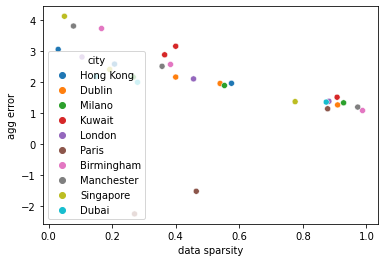

In [31]:
sns.scatterplot(data=city_charts, x='data sparsity', y='agg error', hue='city')
plt.show()

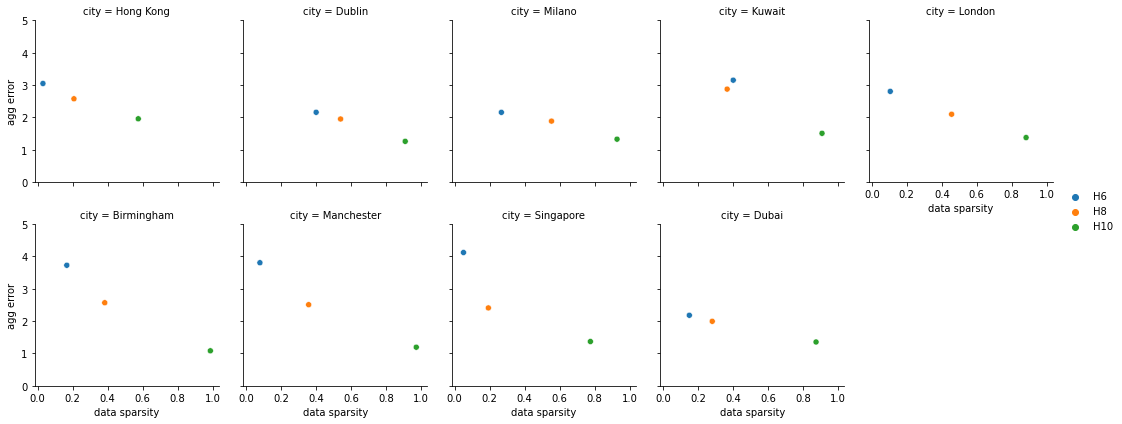

In [47]:
g = sns.FacetGrid(city_charts[city_charts['city']!='Paris'], col="city", col_wrap=5)
g.map_dataframe(sns.scatterplot, x="data sparsity", y="agg error", hue="hex resolution")
# g.refline(y=0, linestyle=":")
g.set(ylim=(0, 5))
g.add_legend()

In [48]:
orders.head()

,ID,BUSINESS_UNIT_NAME,RESTAURANT_CITY_ID,RESTAURANT_CITY_NAME,CUSTOMER_CITY_ID,CUSTOMER_CITY_NAME,RESTAURANT_GEO_LAT,RESTAURANT_GEO_LONG,CUSTOMER_GEO_LAT,CUSTOMER_GEO_LONG,RIDER_EXPERIENCE_TIME,cx_hex_ID
0,903938694,London,1,London,1,London,51.526742,-0.056498,51.526204,-0.039750,NaN,8a194e69b677fff
1,903126855,Paris,6,Paris,6,Paris,48.906937,2.300825,48.914190,2.282710,NaN,8a1fb475c32ffff
2,903624032,Singapore,50,Singapore,50,Singapore,1.305779,103.830897,1.302313,103.841034,NaN,8a6520d9514ffff
3,903763228,London,1,London,1,London,51.579833,-0.333860,51.556050,-0.298267,NaN,8a195daed067fff
4,903537671,Ireland,5,Dublin,5,Dublin,53.395051,-6.265967,53.395051,-6.265967,NaN,8a182c8d33a7fff


In [4]:
q_orders = '''
SELECT * FROM SCRATCH.RIDER_PLANNING.GEOSPATIAL_ES
'''

orders = pd.read_sql(q_orders,con)


In [258]:
lst3=[]
lst4=[]

for i in range(orders.shape[0]):
    hex3=0
    hex3 = h3.geo_to_h3(orders['RX_LAT'][i],orders['RX_LONG'][i], resolution=7)
    hex4=0
    hex4 = h3.geo_to_h3(orders['CX_LAT'][i],orders['CX_LONG'][i], resolution=7)
    lst3.append(hex3)
    lst4.append(hex4)
    if(i%100000 == 0):
        print(i)
orders['rx_hex_ID'] = lst3
orders['cx_hex_ID'] = lst4


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

In [259]:
non_sparse_cx_hexes_tmp = orders.groupby('cx_hex_ID')['ORDER_ID'].count().to_frame().reset_index()
non_sparse_cx_hexes = non_sparse_cx_hexes_tmp[non_sparse_cx_hexes_tmp['ORDER_ID'] >= 100]
data_hex_no_sparse = orders.merge(non_sparse_cx_hexes, how='inner', on='cx_hex_ID')

In [243]:
# sparse_cx_hexes_tmp = orders.groupby('cx_hex_ID')['ORDER_ID'].count().to_frame().reset_index()
# sparse_cx_hexes = sparse_cx_hexes_tmp[sparse_cx_hexes_tmp['ORDER_ID'] < 100]
# data_hex_sparse = orders.merge(sparse_cx_hexes, how='inner', on='cx_hex_ID')

In [80]:
# non_sparse_rx_hexes_tmp = orders.groupby('rx_hex_ID')['ORDER_ID'].count().to_frame().reset_index()
# non_sparse_rx_hexes_tmp[non_sparse_rx_hexes_tmp['ORDER_ID'] < 100]

,rx_hex_ID,ORDER_ID
10,86182c1a7ffffff,39
11,86182c1afffffff,66
12,86182c81fffffff,6
17,86182c8efffffff,40
20,86182ca8fffffff,3
...,...,...
474,86411cb2fffffff,8
483,86411cba7ffffff,62
485,8643a104fffffff,28
508,8643ac1b7ffffff,4


In [260]:
data_hex_no_sparse['PCP2'] = data_hex_no_sparse['PCP']
data_hex_no_sparse.head()


,CITY_NAME,CITY_ID,ORDER_ID_x,CX_ID,CX_LAT,CX_LONG,RX_ID,RX_LAT,RX_LONG,R2C,RET,AOV,PCP,B10,rx_hex_ID,cx_hex_ID,ORDER_ID_y,PCP2
0,Hong Kong,51,866511366,51475844,22.305134,114.166660,238807,22.297598,114.167977,848.0,19.883333,35.36912,5.707995,False,87411cb34ffffff,87411cb34ffffff,33492,5.707995
1,Hong Kong,51,859633414,44841483,22.308113,114.165997,34125,22.307753,114.165737,48.0,35.933333,17.76440,2.532471,False,87411cb34ffffff,87411cb34ffffff,33492,2.532471
2,Hong Kong,51,861416799,5080935,22.298559,114.167933,232741,22.303227,114.166741,533.0,12.866667,13.67260,2.489812,False,87411cb34ffffff,87411cb34ffffff,33492,2.489812
3,Hong Kong,51,861531913,39566282,22.294755,114.166918,21989,22.294755,114.166918,0.0,NaN,33.13360,0.414106,False,87411cb34ffffff,87411cb34ffffff,33492,0.414106
4,Hong Kong,51,880751499,2594651,22.305043,114.166820,36508,22.318555,114.158709,1718.0,2.966667,36.62660,4.094018,False,87411cb36ffffff,87411cb34ffffff,33492,4.094018


In [261]:
city = data_hex_no_sparse.groupby('CITY_NAME').agg({'cx_hex_ID':['nunique'],'rx_hex_ID':['nunique'],'CX_ID':['nunique'],'RX_ID':['nunique'],
                         'ORDER_ID_x':['count'], 'PCP':['sum'], 'PCP2':['mean'],'R2C':['mean'], 'B10':['mean'],
                         'RET':['mean'],
                         'AOV':['mean']})
city.columns = city.columns.map('_'.join)
city = city.reset_index(inplace=False)


In [245]:
# city_sparse = data_hex_sparse.groupby('CITY_NAME').agg({'cx_hex_ID':['nunique'],'rx_hex_ID':['nunique'],'CX_ID':['nunique'],'RX_ID':['nunique'],
#                          'ORDER_ID_x':['count'], 'PCP':['sum'],'R2C':['mean'], 'B10':['mean'],
#                          'RET':['mean'],
#                          'AOV':['mean']})
# city_sparse.columns = city_sparse.columns.map('_'.join)
# city_sparse = city_sparse.reset_index(inplace=False)

In [246]:
# city_sparse.to_clipboard(index=False)

In [131]:
city.head()


,CITY_NAME,cx_hex_ID_nunique,rx_hex_ID_nunique,CX_ID_nunique,RX_ID_nunique,ORDER_ID_x_count,PCP_sum,PCP2_mean,R2C_mean,B10_mean,RET_mean,AOV_mean
0,Birmingham,41,40,152459,2671,379516,3.041574e+05,0.824798,2537.080481,0.019604,18.966169,19.165442
1,Dubai,40,36,242913,5775,1485751,3.223669e+06,2.169723,3303.399381,0.017910,26.068814,16.248399
2,Dublin,21,23,123168,1327,408193,8.204524e+05,2.011998,2099.426950,0.015341,17.144389,21.027265
3,Hong Kong,32,29,396136,9952,1866510,3.238197e+06,1.734894,906.716808,0.017339,16.868668,19.336708
4,Kuwait,30,29,146758,4013,682377,3.655660e+05,0.535724,4100.439326,0.020311,24.027188,14.689205


In [262]:
city = city.rename(columns={'cx_hex_ID_nunique':'cx_hex6_city', 'rx_hex_ID_nunique':'rx_hex6_city',
                            "CX_ID_nunique": "cx_city", "RX_ID_nunique": "rx_city",
                            "ORDER_ID_x_count": "orders_city","PCP_sum": "clv_city",
                            "RET_mean": "ret_city","AOV_mean": "aov_city", "R2C_mean":"r2c_city","PCP2_mean":"pcp_city"})



In [133]:
city.head()


,CITY_NAME,cx_hex6_city,rx_hex6_city,cx_city,rx_city,orders_city,clv_city,pcp_city,r2c_city,B10_mean,ret_city,aov_city
0,Birmingham,41,40,152459,2671,379516,3.041574e+05,0.824798,2537.080481,0.019604,18.966169,19.165442
1,Dubai,40,36,242913,5775,1485751,3.223669e+06,2.169723,3303.399381,0.017910,26.068814,16.248399
2,Dublin,21,23,123168,1327,408193,8.204524e+05,2.011998,2099.426950,0.015341,17.144389,21.027265
3,Hong Kong,32,29,396136,9952,1866510,3.238197e+06,1.734894,906.716808,0.017339,16.868668,19.336708
4,Kuwait,30,29,146758,4013,682377,3.655660e+05,0.535724,4100.439326,0.020311,24.027188,14.689205


In [263]:
labels = list(city['CITY_NAME'].unique())

Text(0, 0.5, 'OV')

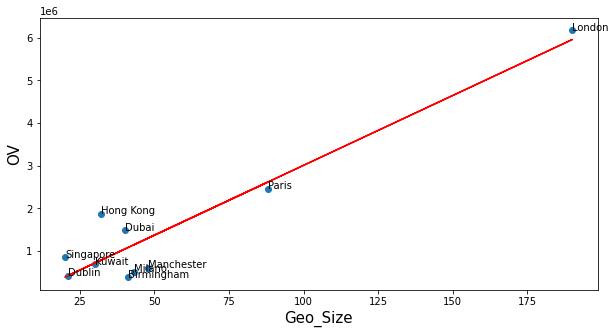

In [89]:
x = city['cx_hex6_city']
y = city['orders_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size", fontsize=15)
plt.ylabel("OV", fontsize=15)

KeyError: 5

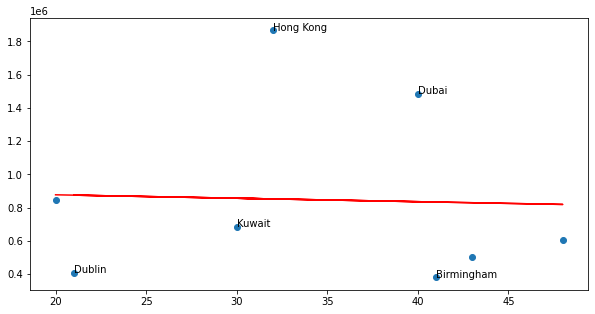

In [88]:
labels_2 = ['Birmingham',
 'Dubai',
 'Dublin',
 'Hong Kong',
 'Kuwait',
 'London',
 'Manchester',
 'Milano',
 'Paris',
 'Singapore']

x = city[(city['CITY_NAME']!= 'Paris') & (city['CITY_NAME']!= 'London')]['cx_hex6_city']
y = city[(city['CITY_NAME']!= 'Paris') & (city['CITY_NAME']!= 'London')]['orders_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels_2):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("OV")

Text(0, 0.5, 'CLV')

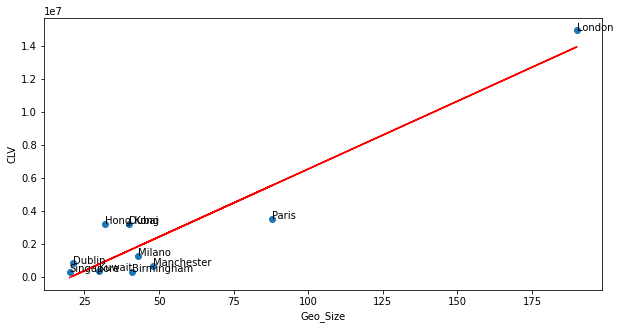

In [42]:
x = city['cx_hex6_city']
y = city['clv_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("CLV")

Text(0, 0.5, 'Avg PCP')

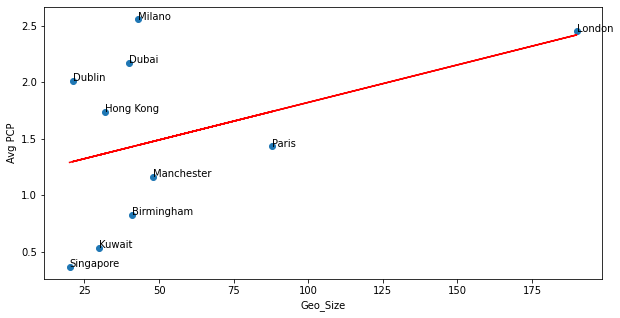

In [134]:
x = city['cx_hex6_city']
y = city['pcp_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("Avg PCP")

Text(0, 0.5, 'AOV')

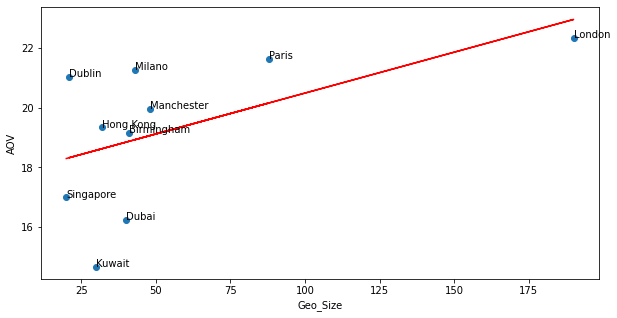

In [41]:
x = city['cx_hex6_city']
y = city['aov_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("AOV")

Text(0, 0.5, 'RET')

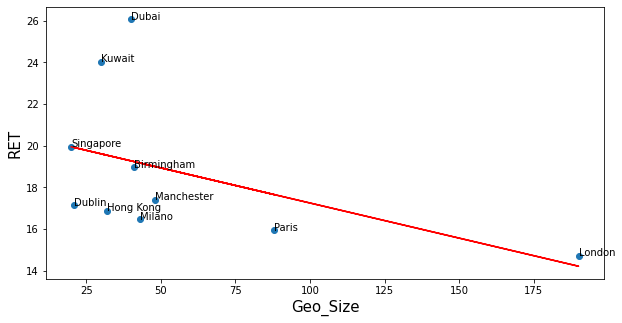

In [90]:
x = city['cx_hex6_city']
y = city['ret_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size", fontsize=15)
plt.ylabel("RET", fontsize=15)

Text(0, 0.5, 'Restaurant-to-customer distance (m)')

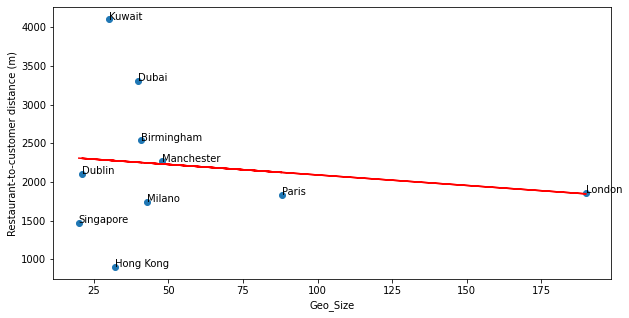

In [44]:
x = city['cx_hex6_city']
y = city['r2c_city']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("Restaurant-to-customer distance (m)")

Text(0, 0.5, 'B10 15+ Late Rate')

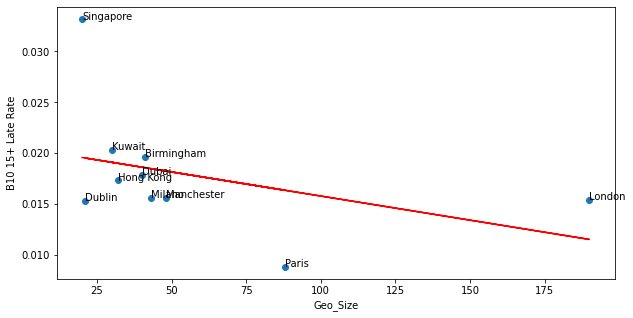

In [221]:
x = city['cx_hex6_city']
y = city['B10_mean']

plt.figure(figsize=(10,5))

#create basic scatterplot
plt.scatter(x, y)

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, 'r')

for i, txt in enumerate(labels):
    plt.annotate(txt, (x[i], y[i]))
    
plt.xlabel("Geo_Size")
plt.ylabel("B10 15+ Late Rate")

# City hex classification

In [264]:
# first, a reference table with all hexes

hex = data_hex_no_sparse[['CITY_NAME','cx_hex_ID']].drop_duplicates()
hex = hex.rename(columns={ "cx_hex_ID": "hex"})
hexx = data_hex_no_sparse[['CITY_NAME','rx_hex_ID']].drop_duplicates()
hexx = hexx.rename(columns={ "rx_hex_ID": "hex"})
hex = hex.append(hexx)
hex = hex.drop_duplicates().reset_index(drop=True)


In [152]:
hex.head()


,CITY_NAME,hex
0,Hong Kong,86411cb37ffffff
1,Paris,861fb466fffffff
2,Paris,861fb475fffffff
3,London,86194ad27ffffff
4,Paris,861fb461fffffff


In [265]:
# aggregating to the hex level , separately for restaurants and customers

cx_hex = data_hex_no_sparse.groupby('cx_hex_ID').agg({'CX_ID':['nunique']})
cx_hex.columns = cx_hex.columns.map('_'.join)
cx_hex = cx_hex.reset_index(inplace=False)
cx_hex = cx_hex.rename(columns={ "CX_ID_nunique": "cx_hex",'cx_hex_ID':'hex'})

rx_hex = data_hex_no_sparse.groupby('rx_hex_ID').agg({'RX_ID':['nunique']})
rx_hex.columns = rx_hex.columns.map('_'.join)
rx_hex = rx_hex.reset_index(inplace=False)
rx_hex = rx_hex.rename(columns={ "RX_ID_nunique": "rx_hex",'rx_hex_ID':'hex'})


In [266]:
# classifying the hexes using medians for the whole sample of hexes, for all the cities

hex = hex.merge(rx_hex, on=['hex'])
hex = hex.merge(cx_hex, on=['hex'])

#median number of customers, restaurants per hex
hex['cx_hex_median']= hex.cx_hex.median()
hex['rx_hex_median']= hex.rx_hex.median()

#classification of individual hexes
hex['hex_class'] = ""
hex.loc[(hex['cx_hex_median'] >= hex['cx_hex']) & (hex['rx_hex_median'] >= hex['rx_hex']), 'hex_class'] = 'sparse'
hex.loc[(hex['cx_hex_median'] < hex['cx_hex']) & (hex['rx_hex_median'] < hex['rx_hex']), 'hex_class'] = 'dense'
hex.loc[(hex['cx_hex_median'] >= hex['cx_hex']) & (hex['rx_hex_median'] < hex['rx_hex']), 'hex_class'] = 'downtown'
hex.loc[(hex['cx_hex_median'] < hex['cx_hex']) & (hex['rx_hex_median'] >= hex['rx_hex']), 'hex_class'] = 'suburban'

In [155]:
hex.head()


,CITY_NAME,hex,rx_hex,cx_hex,cx_hex_median,rx_hex_median,hex_class
0,Hong Kong,86411cb37ffffff,1896,60992,2910.0,38.0,dense
1,Paris,861fb466fffffff,484,30093,2910.0,38.0,dense
2,Paris,861fb475fffffff,1800,105830,2910.0,38.0,dense
3,London,86194ad27ffffff,803,74031,2910.0,38.0,dense
4,Paris,861fb461fffffff,46,2726,2910.0,38.0,downtown


In [156]:
# tabulate to see what this looks like
pd.crosstab(index=hex["CITY_NAME"],columns=hex["hex_class"],margins=True)


hex_class,dense,downtown,sparse,suburban,All
CITY_NAME,,,,,
Birmingham,16,2,19,1,38
Dubai,21,1,12,2,36
Dublin,5,2,10,2,19
Hong Kong,18,2,8,1,29
Kuwait,13,3,8,4,28
London,74,2,85,16,177
Manchester,20,2,19,1,42
Milano,10,0,27,2,39
Paris,35,12,38,0,85


In [267]:
hex_count = hex[['CITY_NAME','hex_class','hex']].groupby(['CITY_NAME','hex_class']).count().reset_index()
hex_count.head(10)


,CITY_NAME,hex_class,hex
0,Birmingham,dense,40
1,Birmingham,downtown,33
2,Birmingham,sparse,92
3,Birmingham,suburban,11
4,Dubai,dense,60
5,Dubai,downtown,16
6,Dubai,sparse,38
7,Dubai,suburban,29
8,Dublin,dense,15
9,Dublin,downtown,9


# City class level

In [268]:
# add hex classifications to the bigger sample - FOR CX-aggregation

hex_cx = hex
hex_cx = hex_cx.rename(columns={ "hex": "cx_hex_ID"})
data_hex_cx = data_hex_no_sparse.merge(hex_cx, on=['cx_hex_ID','CITY_NAME'])
data_hex_cx.head(10)


,CITY_NAME,CITY_ID,ORDER_ID_x,CX_ID,CX_LAT,CX_LONG,RX_ID,RX_LAT,RX_LONG,R2C,...,B10,rx_hex_ID,cx_hex_ID,ORDER_ID_y,PCP2,rx_hex,cx_hex,cx_hex_median,rx_hex_median,hex_class
0,Hong Kong,51,866511366,51475844,22.305134,114.166660,238807,22.297598,114.167977,848.0,...,False,87411cb34ffffff,87411cb34ffffff,33492,5.707995,233,8798,871.0,11.0,dense
1,Hong Kong,51,859633414,44841483,22.308113,114.165997,34125,22.307753,114.165737,48.0,...,False,87411cb34ffffff,87411cb34ffffff,33492,2.532471,233,8798,871.0,11.0,dense
2,Hong Kong,51,861416799,5080935,22.298559,114.167933,232741,22.303227,114.166741,533.0,...,False,87411cb34ffffff,87411cb34ffffff,33492,2.489812,233,8798,871.0,11.0,dense
3,Hong Kong,51,861531913,39566282,22.294755,114.166918,21989,22.294755,114.166918,0.0,...,False,87411cb34ffffff,87411cb34ffffff,33492,0.414106,233,8798,871.0,11.0,dense
4,Hong Kong,51,880751499,2594651,22.305043,114.166820,36508,22.318555,114.158709,1718.0,...,False,87411cb36ffffff,87411cb34ffffff,33492,4.094018,233,8798,871.0,11.0,dense
5,Hong Kong,51,858671181,25093302,22.295347,114.171003,282697,22.299678,114.174288,588.0,...,False,87411c869ffffff,87411cb34ffffff,33492,2.410842,233,8798,871.0,11.0,dense
6,Hong Kong,51,880779562,9470240,22.304321,114.163222,213981,22.307315,114.170575,826.0,...,False,87411c869ffffff,87411cb34ffffff,33492,-1.439390,233,8798,871.0,11.0,dense
7,Hong Kong,51,907436708,11839029,22.304428,114.162955,38544,22.320156,114.161802,1752.0,...,False,87411cb36ffffff,87411cb34ffffff,33492,7.599945,233,8798,871.0,11.0,dense
8,Hong Kong,51,881186663,2841981,22.305637,114.160813,207181,22.294222,114.175090,1941.0,...,False,87411c869ffffff,87411cb34ffffff,33492,0.246999,233,8798,871.0,11.0,dense
9,Hong Kong,51,890347340,33478258,22.306885,114.162434,207181,22.294222,114.175090,1917.0,...,False,87411c869ffffff,87411cb34ffffff,33492,-0.929632,233,8798,871.0,11.0,dense


In [269]:
# aggregate to city-class combination- CX-aggregation
city_class_cx = data_hex_cx.groupby(['CITY_NAME','hex_class']).agg({'CX_ID':['nunique'],
                                                         'ORDER_ID_x':['count'], 'PCP':['sum'], 'R2C':['mean'], 'B10':['mean'],
                                                         'RET':['mean'], 'PCP2':['mean'],
                                                         'AOV':['mean']})
city_class_cx.columns = city_class_cx.columns.map('_'.join)
city_class_cx = city_class_cx.reset_index(inplace=False)
city_class_cx = city_class_cx.rename(columns={
                            "CX_ID_nunique": "cx_class",
                            "ORDER_ID_x_count": "cx_orders_class","PCP_sum": "cx_clv_class", "PCP2_mean":"cx_pcp_class",
                            "RET_mean": "cx_ret_class","AOV_mean": "cx_aov_class","R2C_mean":"cx_r2c_class",
                            "B10_mean":"cx_b10_class"})

In [270]:
# add hex classifications to the bigger sample - FOR RX-aggregation

hex_rx = hex
hex_rx = hex_rx.rename(columns={ "hex": "rx_hex_ID"})
data_hex_rx = data_hex_no_sparse.merge(hex_rx, on=['rx_hex_ID','CITY_NAME'])

# aggregate to city-class combination- RX-aggregation
city_class_rx = data_hex_rx.groupby(['CITY_NAME','hex_class']).agg({'RX_ID':['nunique'],
                                                         'ORDER_ID_x':['count'], 'PCP':['sum'], 'R2C':['mean'], 'B10':['mean'],
                                                         'RET':['mean'],'PCP2':['mean'],
                                                         'AOV':['mean']})
city_class_rx.columns = city_class_rx.columns.map('_'.join)
city_class_rx = city_class_rx.reset_index(inplace=False)
city_class_rx = city_class_rx.rename(columns={
                            "RX_ID_nunique": "rx_class",
                            "ORDER_ID_x_count": "rx_orders_class","PCP_sum": "rx_clv_class","PCP2_mean":"rx_pcp_class",
                            "RET_mean": "rx_ret_class","AOV_mean": "rx_aov_class","R2C_mean":"rx_r2c_class",
                            "B10_mean":"rx_b10_class"})

In [271]:
city_class = city[['CITY_NAME','cx_city','rx_city','orders_city','clv_city','r2c_city','B10_mean','ret_city','aov_city','pcp_city']].merge(city_class_rx, on=['CITY_NAME'], how='outer')
city_class = city_class.merge(hex_count, on=['CITY_NAME','hex_class'])
city_class = city_class.merge(city_class_cx, on=['CITY_NAME','hex_class'], how='outer')
city_class.head(3)

,CITY_NAME,cx_city,rx_city,orders_city,clv_city,r2c_city,B10_mean,ret_city,aov_city,pcp_city,...,rx_aov_class,hex,cx_class,cx_orders_class,cx_clv_class,cx_r2c_class,cx_b10_class,cx_ret_class,cx_pcp_class,cx_aov_class
0,Birmingham,151989,2670,378531,303875.927615,2533.172813,0.019573,18.956928,19.157228,0.826176,...,18.947407,40,86476,228539,209184.293013,2266.633367,0.019314,17.954743,0.934038,18.657162
1,Birmingham,151989,2670,378531,303875.927615,2533.172813,0.019573,18.956928,19.157228,0.826176,...,20.167636,33,19350,39837,12053.718133,2605.749554,0.022642,20.901502,0.317889,18.728676
2,Birmingham,151989,2670,378531,303875.927615,2533.172813,0.019573,18.956928,19.157228,0.826176,...,18.602807,92,34380,71326,40677.287734,3163.524409,0.020848,21.282710,0.596231,20.126553


In [272]:
# adding the total hexes in a city 

hex_city = city_class[['hex','CITY_NAME']].groupby('CITY_NAME').agg({'hex':['sum']}).reset_index(inplace=False)
hex_city.columns = hex_city.columns.map('_'.join)
hex_city = hex_city.rename(columns={ "hex_sum": "hex_city","CITY_NAME_": "CITY_NAME" })


In [273]:
city_class = city_class.merge(hex_city, on=['CITY_NAME'], how='outer')
city_class['hex_share'] = city_class['hex']/city_class['hex_city']


In [274]:
city_class['cx_share'] = city_class['cx_class']/city_class['cx_city']
city_class['rx_share'] = city_class['rx_class']/city_class['rx_city']


In [275]:
# business metrics relative to the city average, CX-aggregation

city_class['cx_orders_share'] = city_class['cx_orders_class']/city_class['orders_city']
city_class['cx_clv_share'] = city_class['cx_clv_class']/city_class['clv_city']

city_class['cx_aov_dev'] = (city_class['cx_aov_class']-city_class['aov_city'])/city_class['aov_city']
city_class['cx_ret_dev'] = (city_class['cx_ret_class']-city_class['ret_city'])/city_class['ret_city']
city_class['cx_b10_dev'] = (city_class['cx_b10_class']-city_class['B10_mean'])/city_class['B10_mean']
city_class['cx_r2c_dev'] = (city_class['cx_r2c_class']-city_class['r2c_city'])/city_class['r2c_city']
city_class['cx_pcp_dev'] = (city_class['cx_pcp_class']-city_class['pcp_city'])/city_class['pcp_city']


In [276]:
# business metrics relative to the city average, RX-aggregation

city_class['rx_orders_share'] = city_class['rx_orders_class']/city_class['orders_city']
city_class['rx_clv_share'] = city_class['rx_clv_class']/city_class['clv_city']

city_class['rx_aov_dev'] = (city_class['rx_aov_class']-city_class['aov_city'])/city_class['aov_city']
city_class['rx_ret_dev'] = (city_class['rx_ret_class']-city_class['ret_city'])/city_class['ret_city']
city_class['rx_b10_dev'] = (city_class['rx_b10_class']-city_class['B10_mean'])/city_class['B10_mean']
city_class['rx_r2c_dev'] = (city_class['rx_r2c_class']-city_class['r2c_city'])/city_class['r2c_city']
city_class['rx_pcp_dev'] = (city_class['rx_pcp_class']-city_class['pcp_city'])/city_class['pcp_city']



In [277]:
city_class.to_clipboard(index=False)
city_class.head(10)


,CITY_NAME,cx_city,rx_city,orders_city,clv_city,r2c_city,B10_mean,ret_city,aov_city,pcp_city,...,cx_b10_dev,cx_r2c_dev,cx_pcp_dev,rx_orders_share,rx_clv_share,rx_aov_dev,rx_ret_dev,rx_b10_dev,rx_r2c_dev,rx_pcp_dev
0,Birmingham,151989,2670,378531,3.038759e+05,2533.172813,0.019573,18.956928,19.157228,0.826176,...,-0.013235,-0.105220,0.130555,0.714066,0.834946,-0.010953,-0.035289,-0.038846,-0.036012,0.165970
1,Birmingham,151989,2670,378531,3.038759e+05,2533.172813,0.019573,18.956928,19.157228,0.826176,...,0.156809,0.028651,-0.615229,0.162901,0.075817,0.052743,0.138624,0.154995,0.115594,-0.520168
2,Birmingham,151989,2670,378531,3.038759e+05,2533.172813,0.019573,18.956928,19.157228,0.826176,...,0.065136,0.248839,-0.278324,0.097363,0.049022,-0.028941,0.054896,0.100692,0.067357,-0.507207
3,Birmingham,151989,2670,378531,3.038759e+05,2533.172813,0.019573,18.956928,19.157228,0.826176,...,-0.275748,0.084301,0.469252,0.025216,0.040409,0.077519,-0.099647,-0.320218,0.003664,0.557137
4,Dubai,242715,5774,1484745,3.222440e+06,3301.997542,0.017901,26.065312,16.250228,2.170366,...,-0.055255,-0.143447,0.002573,0.869640,0.916730,0.018444,-0.002261,-0.019433,-0.025598,0.054149
5,Dubai,242715,5774,1484745,3.222440e+06,3301.997542,0.017901,26.065312,16.250228,2.170366,...,0.348011,0.127378,-0.254160,0.071191,0.051805,-0.090944,0.041889,0.147884,0.267677,-0.272311
6,Dubai,242715,5774,1484745,3.222440e+06,3301.997542,0.017901,26.065312,16.250228,2.170366,...,0.440011,0.414915,-0.191259,0.019728,0.010182,-0.128649,0.105623,0.352151,0.259750,-0.483905
7,Dubai,242715,5774,1484745,3.222440e+06,3301.997542,0.017901,26.065312,16.250228,2.170366,...,0.069438,0.421259,0.010482,0.037724,0.019666,-0.188295,-0.096718,-0.020602,-0.088646,-0.478686
8,Dublin,122642,1319,407267,8.218926e+05,2096.624784,0.015250,17.126430,21.025868,2.020112,...,-0.168269,-0.155374,0.186246,0.901114,0.958171,-0.002456,-0.028926,-0.104849,-0.014361,0.062807
9,Dublin,122642,1319,407267,8.218926e+05,2096.624784,0.015250,17.126430,21.025868,2.020112,...,1.405934,-0.015991,-0.681991,0.050944,0.020503,0.048521,0.385472,1.392419,0.129022,-0.595649


# Hex grouping

In [171]:
data_hex_no_sparse.head()


,CITY_NAME,CITY_ID,ORDER_ID_x,CX_ID,CX_LAT,CX_LONG,RX_ID,RX_LAT,RX_LONG,R2C,RET,AOV,PCP,B10,rx_hex_ID,cx_hex_ID,ORDER_ID_y,PCP2
0,Hong Kong,51,866511366,51475844,22.305134,114.166660,238807,22.297598,114.167977,848.0,19.883333,35.36912,5.707995,False,86411cb37ffffff,86411cb37ffffff,265549,5.707995
1,Hong Kong,51,866044443,33855127,22.329255,114.156894,338124,22.336090,114.147558,1224.0,16.083333,10.57880,-0.588409,False,86411cb37ffffff,86411cb37ffffff,265549,-0.588409
2,Hong Kong,51,859633414,44841483,22.308113,114.165997,34125,22.307753,114.165737,48.0,35.933333,17.76440,2.532471,False,86411cb37ffffff,86411cb37ffffff,265549,2.532471
3,Hong Kong,51,861416799,5080935,22.298559,114.167933,232741,22.303227,114.166741,533.0,12.866667,13.67260,2.489812,False,86411cb37ffffff,86411cb37ffffff,265549,2.489812
4,Hong Kong,51,861531913,39566282,22.294755,114.166918,21989,22.294755,114.166918,0.0,NaN,33.13360,0.414106,False,86411cb37ffffff,86411cb37ffffff,265549,0.414106


In [172]:
city.head()


,CITY_NAME,cx_hex6_city,rx_hex6_city,cx_city,rx_city,orders_city,clv_city,pcp_city,r2c_city,B10_mean,ret_city,aov_city
0,Birmingham,41,40,152459,2671,379516,3.041574e+05,0.824798,2537.080481,0.019604,18.966169,19.165442
1,Dubai,40,36,242913,5775,1485751,3.223669e+06,2.169723,3303.399381,0.017910,26.068814,16.248399
2,Dublin,21,23,123168,1327,408193,8.204524e+05,2.011998,2099.426950,0.015341,17.144389,21.027265
3,Hong Kong,32,29,396136,9952,1866510,3.238197e+06,1.734894,906.716808,0.017339,16.868668,19.336708
4,Kuwait,30,29,146758,4013,682377,3.655660e+05,0.535724,4100.439326,0.020311,24.027188,14.689205


In [187]:
hex_grouped = data_hex_no_sparse.groupby(['CITY_NAME','cx_hex_ID']).agg({'ORDER_ID_x':['count'],'CX_ID':['nunique'],'RX_ID':['nunique'],
                                                  'PCP':['sum'],'PCP2':['mean'],'RET':['mean'],'AOV':['mean'],'B10':['mean'],'R2C':['mean']})
hex_grouped.columns = hex_grouped.columns.map('_'.join)
hex_grouped = hex_grouped.reset_index(inplace=False)
hex_grouped = hex_grouped.rename(columns={
                            "CX_ID_nunique": "cx_hex", "RX_ID_nunique":"rx_hex",
                            "ORDER_ID_x_count": "cx_orders_hex","PCP_sum": "cx_clv_hex", "PCP2_mean":"cx_pcp_hex",
                            "RET_mean": "cx_ret_hex","AOV_mean": "cx_aov_hex","R2C_mean":"cx_r2c_hex",
                            "B10_mean":"cx_b10_hex"})

In [188]:
hex.dtypes


CITY_NAME         object
hex               object
rx_hex             int64
cx_hex             int64
cx_hex_median    float64
rx_hex_median    float64
hex_class         object
dtype: object

In [189]:
hex_grouped_class = hex_grouped.merge(hex[['hex','hex_class']], how='left', left_on='cx_hex_ID',right_on='hex')
hex_grouped_class.sort_values(by=['CITY_NAME','hex_class'])


,CITY_NAME,cx_hex_ID,cx_orders_hex,cx_hex,rx_hex,cx_clv_hex,cx_pcp_hex,cx_ret_hex,cx_aov_hex,cx_b10_hex,cx_r2c_hex,hex,hex_class
1,Birmingham,86195c00fffffff,6152,3138,213,1088.534067,0.186873,21.614143,18.815198,0.025683,2439.560143,86195c00fffffff,dense
7,Birmingham,86195c047ffffff,16689,7405,464,11437.079297,0.703950,18.371319,18.978089,0.014800,2721.803763,86195c047ffffff,dense
8,Birmingham,86195c04fffffff,17755,7777,804,-8740.512759,-0.513785,21.813495,16.336235,0.023148,2788.601690,86195c04fffffff,dense
9,Birmingham,86195c057ffffff,8251,3996,490,1644.905246,0.207900,22.949733,19.013080,0.023755,3409.144346,86195c057ffffff,dense
10,Birmingham,86195c05fffffff,86522,31980,1006,95285.854936,1.114872,16.975726,18.419363,0.021104,1741.813550,86195c05fffffff,dense
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Singapore,866520cafffffff,6119,2099,239,-3881.262474,-0.635543,25.340214,12.917931,0.057853,2024.465272,866520cafffffff,downtown
550,Singapore,866526ad7ffffff,464,262,80,-148.011239,-0.318990,23.816623,15.230406,0.103448,2359.920259,866526ad7ffffff,downtown
540,Singapore,866520da7ffffff,2645,820,165,3712.163127,1.403464,25.347711,27.967128,0.048015,2784.848771,866520da7ffffff,sparse
544,Singapore,86652635fffffff,372,126,144,334.574917,0.899395,25.599226,18.166286,0.061828,3186.166667,86652635fffffff,sparse


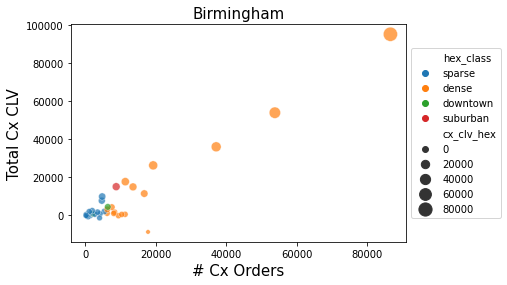

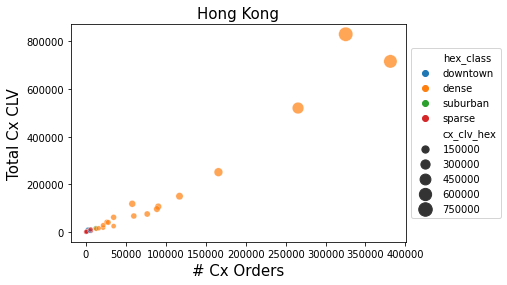

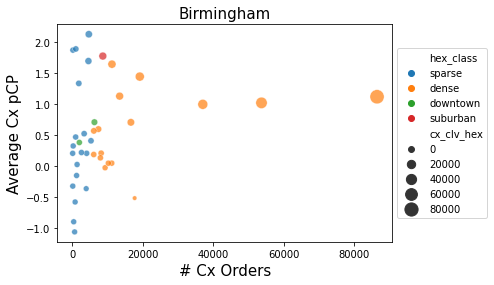

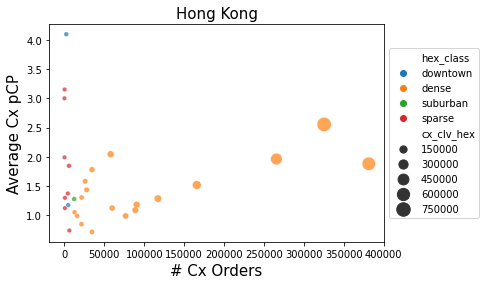

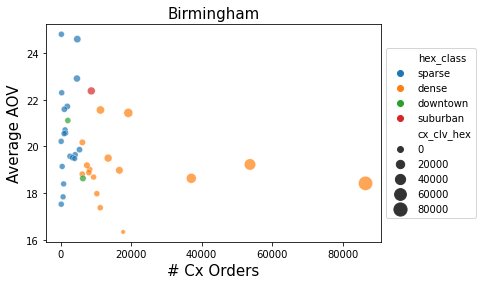

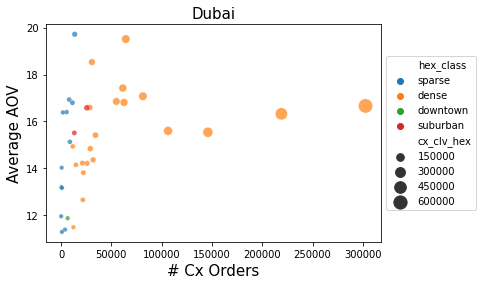

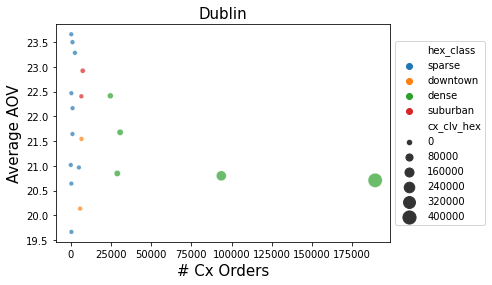

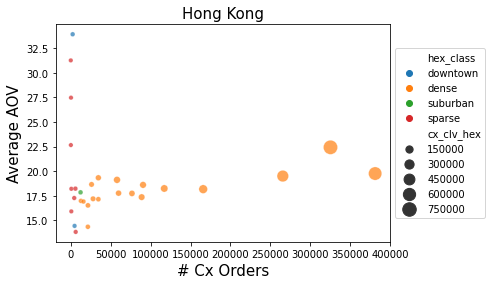

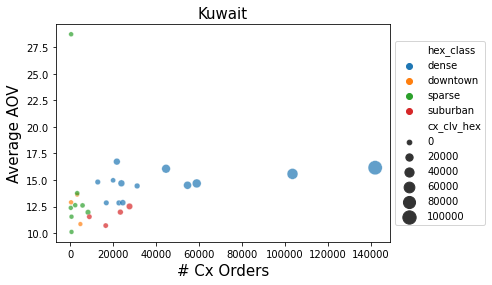

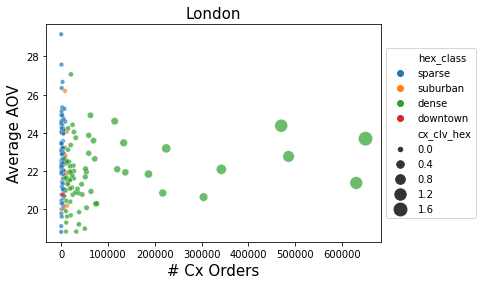

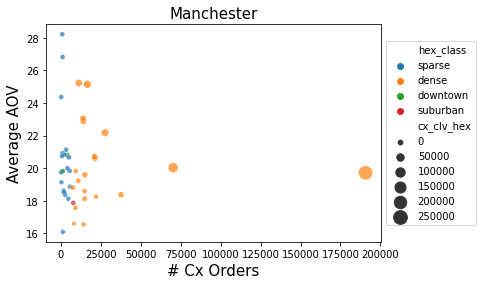

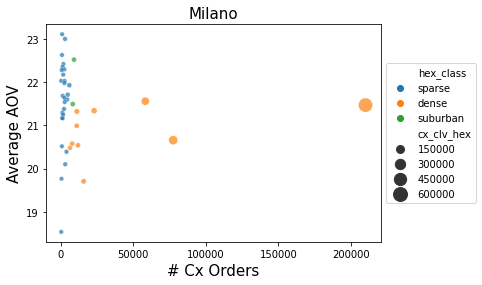

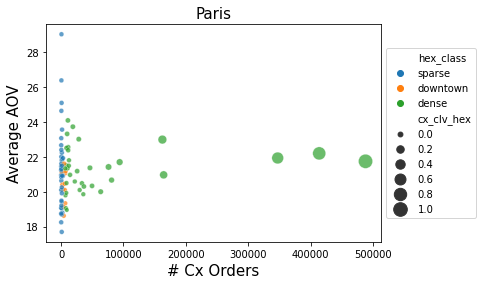

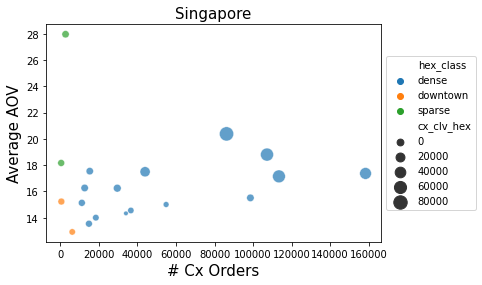

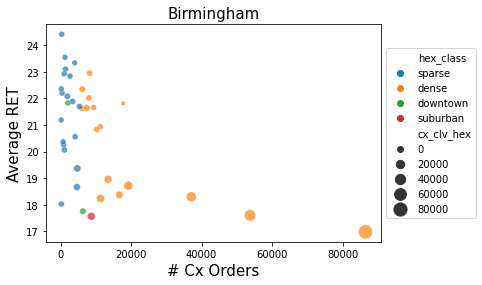

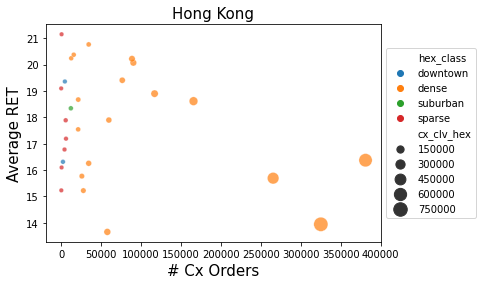

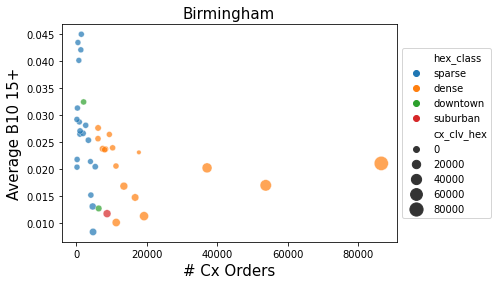

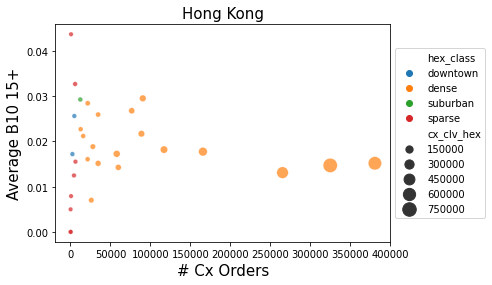

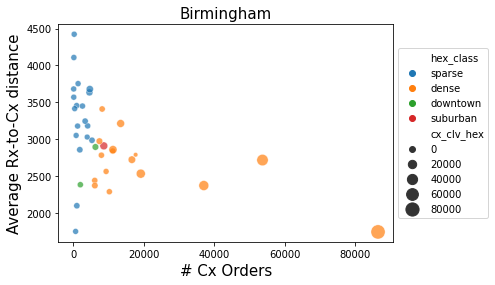

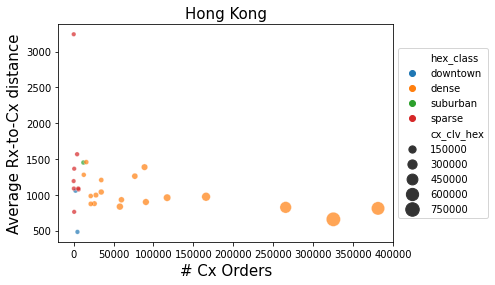

In [234]:
#number of orders correlation with business metrics
for x in ['Birmingham','Hong Kong']:
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Total Cx CLV', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()
    
for x in ['Birmingham','Hong Kong']:
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_pcp_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Average Cx pCP', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()
    
for x in hex_grouped_class['CITY_NAME'].unique():
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_aov_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Average AOV', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()
    
for x in ['Birmingham','Hong Kong']:
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_ret_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Average RET', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()
    
for x in ['Birmingham','Hong Kong']:
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_b10_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Average B10 15+', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()
    
for x in ['Birmingham','Hong Kong']:
    sns.scatterplot(x=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_orders_hex'], y=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_r2c_hex'],
                    hue=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['hex_class'], alpha=0.7, size=hex_grouped_class[hex_grouped_class['CITY_NAME']==x]['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Average Rx-to-Cx distance', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(x, fontsize=15)
    plt.show()

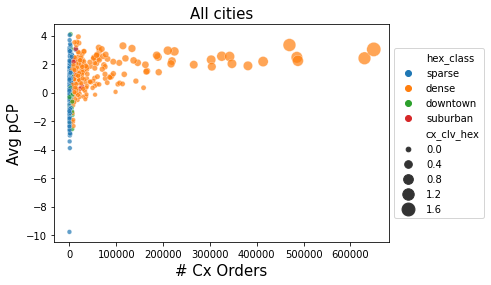

In [242]:

    sns.scatterplot(x=hex_grouped_class['cx_orders_hex'], y=hex_grouped_class['cx_pcp_hex'],
                    hue=hex_grouped_class['hex_class'], alpha=0.7, size=hex_grouped_class['cx_clv_hex']
                   ,sizes=(20, 200))
    plt.xlabel('# Cx Orders', fontsize=15)
    plt.ylabel('Avg pCP', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('All cities', fontsize=15)
    plt.show()

In [307]:
hex_grouped_class[hex_grouped_class['CITY_NAME']=='Birmingham'][['cx_hex_ID','cx_ret_hex','cx_aov_hex']].sort_values(by='cx_ret_hex')


,cx_hex_ID,cx_ret_hex,cx_aov_hex
10,86195c05fffffff,16.975726,18.419363
11,86195c067ffffff,17.562217,22.384124
35,86195c3b7ffffff,17.599238,19.229553
31,86195c397ffffff,17.752010,18.633418
24,86195c15fffffff,18.024381,24.814410
34,86195c3afffffff,18.234201,21.565621
33,86195c3a7ffffff,18.299938,18.635754
7,86195c047ffffff,18.371319,18.978089
32,86195c39fffffff,18.530551,17.837755
13,86195c077ffffff,18.663122,22.914962


In [309]:
hex_grouped_class[['cx_ret_hex','cx_aov_hex']].corr()

,cx_ret_hex,cx_aov_hex
cx_ret_hex,1.000000,-0.475567
cx_aov_hex,-0.475567,1.000000


In [247]:
orders_10 = orders

lst5=[]
lst6=[]

for i in range(orders_10.shape[0]):
    hex5=0
    hex5 = h3.geo_to_h3(orders_10['RX_LAT'][i],orders_10['RX_LONG'][i], resolution=10)
    hex6=0
    hex6 = h3.geo_to_h3(orders_10['CX_LAT'][i],orders_10['CX_LONG'][i], resolution=10)
    lst5.append(hex5)
    lst6.append(hex6)
    if(i%100000 == 0):
        print(i)
orders_10['rx_hex_ID'] = lst5
orders_10['cx_hex_ID'] = lst6

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

In [248]:
non_sparse_cx_hexes_tmp_10 = orders_10.groupby('cx_hex_ID')['ORDER_ID'].count().to_frame().reset_index()
non_sparse_cx_hexes_10 = non_sparse_cx_hexes_tmp_10[non_sparse_cx_hexes_tmp_10['ORDER_ID'] >= 100]
data_hex_no_sparse_10 = orders_10.merge(non_sparse_cx_hexes_10, how='inner', on='cx_hex_ID')

In [250]:
city_10 = data_hex_no_sparse_10.groupby('CITY_NAME').agg({'cx_hex_ID':['nunique'],'rx_hex_ID':['nunique'],'CX_ID':['nunique'],'RX_ID':['nunique'],
                         'ORDER_ID_x':['count'], 'PCP':['sum'], 'R2C':['mean'], 'B10':['mean'],
                         'RET':['mean'],
                         'AOV':['mean']})
city_10.columns = city_10.columns.map('_'.join)
city_10 = city_10.reset_index(inplace=False)

In [251]:
sparse_cx_hexes_tmp_10 = orders_10.groupby('cx_hex_ID')['ORDER_ID'].count().to_frame().reset_index()
sparse_cx_hexes_10 = sparse_cx_hexes_tmp_10[sparse_cx_hexes_tmp_10['ORDER_ID'] < 100]
data_hex_sparse_10 = orders_10.merge(sparse_cx_hexes_10, how='inner', on='cx_hex_ID')

In [252]:
city_sparse_10 = data_hex_sparse_10.groupby('CITY_NAME').agg({'cx_hex_ID':['nunique'],'rx_hex_ID':['nunique'],'CX_ID':['nunique'],'RX_ID':['nunique'],
                         'ORDER_ID_x':['count'], 'PCP':['sum'],'R2C':['mean'], 'B10':['mean'],
                         'RET':['mean'],
                         'AOV':['mean']})
city_sparse_10.columns = city_sparse_10.columns.map('_'.join)
city_sparse_10 = city_sparse_10.reset_index(inplace=False)

In [257]:
city_sparse['PCP_sum'].sum()/city['clv_city'].sum()

7.558600144497065e-05